# Bandit pegasosQSVC FL in Genomic dataset

 This algorithm is a QFL framework that allow clients to use greedy policy to interact with environment. It is implemented in genomic dataset, in whose scenario the client can get feedback, and use the feedback as part of the new training dataset, to allow them converge in an uncertain environment. 

## Load Genomic dataset

In [1]:
from genomic_benchmarks.dataset_getters.pytorch_datasets import DemoHumanOrWorm

#test_set = DemoHumanOrWorm(split='test', version=0)
train_set = DemoHumanOrWorm(split='train', version=0)

data_set = train_set
# data_set = train_set + test_set
#print(f"Nuber of samples in the test set: {len(test_set)}")
print(f"Nuber of samples in the train set: {len(train_set)}")

d:\Software\Anaconda2022.10\envs\qfl\lib\site-packages\genomic_benchmarks\utils\datasets.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


Nuber of samples in the train set: 75000


## Genomics Data

Now, let's take a closer look at what the genomic data looks like. The data consists of DNA sequences, each represented as a string with a length of 200 characters, and an associated label, which can be either 0 or 1. In this context, 0 typically represents human DNA, while 1 corresponds to worm DNA.

For our specific use case, we need to reduce the dimensionality of this data. One approach is to encode the DNA sequence characters as follows:
- 'A' as 1
- 'T' as 2
- 'C' as 3
- 'G' as 4
- 'N' as 5

Since we know that DNA sequences contain only these characters. However, working with 200 features for each sequence might be too complex. In the next step, we'll work on reducing the dimensionality of this data from 200 features down to a single digit, such as 5 or 4.
## Creating a Dictionary of DNA Sequence Representations

In the following code snippet, we create a dictionary named `word_combinations`. This dictionary is designed to hold numerical representations of DNA sequences. Our goal is to convert the DNA sequences into a more manageable format.

To achieve this, we define a variable called `word_size`, which specifies the length of each word we want to consider in the DNA sequence. In this particular case, `word_size` is set to 40, but you can adjust it based on your specific requirements.

The code iterates through each DNA sequence in the `data_set` and extracts overlapping subsequences of length `word_size`. These subsequences are represented as "words." For each unique word encountered in the DNA sequences, we assign a numerical representation.

The resulting `word_combinations` dictionary stores these numerical representations, allowing us to work with a simplified version of the DNA data.


In [2]:
from collections import defaultdict
import numpy as np

word_size = 40
word_combinations = defaultdict(int)
iteration = 1
for text, _ in data_set:
    for i in range(len(text)):
        word = text[i:i+word_size]
        if word_combinations.get(word) is None:
          word_combinations[word] = iteration
          iteration += 1


In [3]:
print("First sample int the data_set variable: ")
print(data_set[0])

print("\nFirst 5 samples in the word_combinations dict.")
for key, value in list(word_combinations.items())[:5]:
    print(key, value)

First sample int the data_set variable: 
('TCAGCCTCCCAAGTAGCTGGGACTACATGCCCTTGCCTCTGCTTTGTTTTCCATTATTTTCTCACATGTCAGGCTTCATTATATGTTTCACAGTCTTTATTATTATTTACCTTCCTCAGCTAGAATGTGAGTCCACAAGGATAGGTCTGAACTCTTTTACTCACAGCATTTCTGACCCCCAAATATGTGTCTTTTGTCCT', 0)

First 5 samples in the word_combinations dict.
TCAGCCTCCCAAGTAGCTGGGACTACATGCCCTTGCCTCT 1
CAGCCTCCCAAGTAGCTGGGACTACATGCCCTTGCCTCTG 2
AGCCTCCCAAGTAGCTGGGACTACATGCCCTTGCCTCTGC 3
GCCTCCCAAGTAGCTGGGACTACATGCCCTTGCCTCTGCT 4
CCTCCCAAGTAGCTGGGACTACATGCCCTTGCCTCTGCTT 5


## Encoding DNA Sequences

In the following code segment, we encode the 200-character DNA sequences into smaller samples, each comprising 200 divided by the `word_size` segments. This encoding allows us to represent the DNA sequences in a numerical format by assigning a numerical value from the `word_combinations` dictionary to each segment.

The specific steps in the code include:
1. Stripping any leading or trailing whitespace from the DNA sequence.
2. Dividing the DNA sequence into `word_size`-letter word segments using a sliding window approach.
3. Converting these word segments into their corresponding numerical values as per the `word_combinations` dictionary.
4. Organizing the data into a structured format that includes the numerical sequence and its associated label.

The resulting `np_data_set` holds these encoded data points.

In [4]:
import numpy as np
# Preprocess the training set
np_data_set = []
for i in range(len(data_set)):
    sequence, label = data_set[i]
    sequence = sequence.strip()  # Remove any leading/trailing whitespace
    words = [sequence[i:i + word_size] for i in range(0, len(sequence), word_size)]  # Split the sequence into 4-letter words
    int_sequence = np.array([word_combinations[word] for word in words])
    data_point = {'sequence': int_sequence, 'label': label}
    np_data_set.append(data_point)


print("First 5 samples of encoded data:")
np_data_set[:5]

First 5 samples of encoded data:


[{'sequence': array([  1,  41,  81, 121, 161]), 'label': 0},
 {'sequence': array([201, 201, 201, 201, 201]), 'label': 0},
 {'sequence': array([241, 281, 321, 361, 401]), 'label': 0},
 {'sequence': array([441, 481, 521, 561, 601]), 'label': 0},
 {'sequence': array([641, 681, 721, 761, 801]), 'label': 0}]

## Shuffling Data for Balanced Distribution

In the code segment above, we observe the first 5 samples of the `np_data_set` variable. It's apparent that all of these initial samples have a label of 0. This observation is due to the common dataset structure, where the data is organized such that the first batch of samples belongs to one class (in this case, class 0), followed by another class (class 1), and so on.

However, in the subsequent steps of this code, we'll divide the data into portions for each of our clients, and it's crucial to ensure that each client receives a balanced mix of data from both classes (0 and 1). Therefore, we need to shuffle the `np_data_set` variable.

Shuffling the dataset randomizes the order of samples, guaranteeing that no single client will receive data only from one class. This is essential for a more representative and fair distribution of data among clients.

In [5]:
np.random.shuffle(np_data_set)
print("First 5 samples of encoded shuffled data:")
np_data_set[:5]

First 5 samples of encoded shuffled data:


[{'sequence': array([9584281, 9584321, 9584361, 9584401, 9584441]),
  'label': 1},
 {'sequence': array([2298485, 2298525, 2298565, 2298605, 2298645]),
  'label': 0},
 {'sequence': array([8732118, 8732158, 8732198, 8732238, 8732278]),
  'label': 1},
 {'sequence': array([13602958, 13602998, 13603038, 13603078, 13603118]),
  'label': 1},
 {'sequence': array([6502559, 6502599, 6502639, 6502679, 6502719]),
  'label': 0}]

## Scaling the Data with Min-Max Scaling

In the code provided, we apply Min-Max scaling to the dataset to normalize the numerical values. This process is valuable for ensuring that the features of the dataset are within a consistent range, typically between 0 and 1.

Here's how the code accomplishes this:
1. We collect the sequences from the `np_data_set` variable and stack them into an array.
2. We create a `MinMaxScaler` object, which will be used to perform the scaling.
3. The scaler is then applied to the sequences using `scaler.fit_transform()`.
4. The scaled sequences are replaced in each data point within the `np_data_set` variable.

As a result, the sequences' values are transformed to a standardized scale, making it easier to work with the data and ensuring that each feature has the same weight in subsequent analyses.

The output displays the first 5 samples of the scaled, encoded, and shuffled data, highlighting how the values are now in the [0, 1] range after the scaling process.

In [6]:
from sklearn.preprocessing import MinMaxScaler

sequences = np.array([item['sequence'] for item in np_data_set])
sequences = np.vstack(sequences)

scaler = MinMaxScaler()

sequences_scaled = scaler.fit_transform(sequences)

for i, item in enumerate(np_data_set):
    item['sequence'] = sequences_scaled[i]

print("First 5 samples of scaled encoded shuffled data:")
np_data_set[:5]

First 5 samples of scaled encoded shuffled data:


[{'sequence': array([0.69460777, 0.69460777, 0.69460153, 0.69460153, 0.69460153]),
  'label': 1},
 {'sequence': array([0.16657953, 0.16657953, 0.16657803, 0.16657803, 0.16657803]),
  'label': 0},
 {'sequence': array([0.63284841, 0.63284841, 0.63284272, 0.63284272, 0.63284272]),
  'label': 1},
 {'sequence': array([0.98585597, 0.98585597, 0.98584711, 0.98584711, 0.98584711]),
  'label': 1},
 {'sequence': array([0.47126412, 0.47126412, 0.47125989, 0.47125989, 0.47125989]),
  'label': 0}]

## Splitting the Dataset and Preparing Test Data

In the previous section, we divided the `np_data_set` variable into two subsets, with 70,000 samples earmarked for training and 5,000 samples reserved for testing. This division is crucial for the development and evaluation of our Quantum Federated Learning model, ensuring that we have separate datasets for these purposes.

Following the split, we proceed to prepare the test data for further analysis and evaluation. We extract the sequences and labels from the testing dataset. This separation is essential as it allows us to analyze the data and labels separately, facilitating model evaluation and performance assessment.

At this point, the test data is organized into two variables:
- `test_sequences`: An array containing the sequences from the test data.
- `test_labels`: An array containing the corresponding labels from the test data.

These variables will be used in subsequent steps to evaluate the model's performance on the testing data.


In [7]:
features = [data_point["sequence"] for data_point in np_data_set]
labels = [data_point["label"] for data_point in np_data_set]
features = np.array(features)
labels = np.array(labels)
print(features[:5])
print(labels[:5])

[[0.69460777 0.69460777 0.69460153 0.69460153 0.69460153]
 [0.16657953 0.16657953 0.16657803 0.16657803 0.16657803]
 [0.63284841 0.63284841 0.63284272 0.63284272 0.63284272]
 [0.98585597 0.98585597 0.98584711 0.98584711 0.98584711]
 [0.47126412 0.47126412 0.47125989 0.47125989 0.47125989]]
[1 0 1 1 0]


## Training with QNN

Before we train a model, we should split the dataset into two parts: a training dataset and a test dataset. We'll use the former to train the model and the latter to verify how well our models perform on unseen data.

As usual, we'll ask scikit-learn to do the boring job for us. We'll also fix the seed to ensure the results are reproducible.

In [8]:
from sklearn.model_selection import train_test_split
from qiskit_algorithms.utils import algorithm_globals

algorithm_globals.random_seed = 123
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=0.8, random_state=algorithm_globals.random_seed
)
print(train_features[:8], test_features[:8], train_labels[:8], test_labels[:8])
train_set = []
test_set = []
for i in range(len(train_features)):
    train = {'sequence': train_features[i], 'label': train_labels[i]}
    train_set.append(train)
for i in range(len(test_features)):
    test = {'sequence': test_features[i], 'label': test_labels[i]}
    test_set.append(test)



[[0.34851166 0.34851166 0.34850853 0.34850853 0.34850853]
 [0.59906873 0.59906873 0.59906334 0.59906334 0.59906334]
 [0.72298077 0.72298077 0.72297427 0.72297427 0.72297427]
 [0.44203449 0.44203449 0.44203051 0.44203051 0.44203051]
 [0.13108367 0.13108367 0.1310825  0.1310825  0.1310825 ]
 [0.12211992 0.12211992 0.12211882 0.12211882 0.12211882]
 [0.97912679 0.97912679 0.97911799 0.97911799 0.97911799]
 [0.20804649 0.20804649 0.20804462 0.20804462 0.20804462]] [[7.03098785e-02 7.03098785e-02 7.03092466e-02 7.03092466e-02
  7.03092466e-02]
 [1.44947304e-05 1.15957843e-05 8.69676007e-06 5.79784004e-06
  2.89892002e-06]
 [2.65628979e-01 2.65628979e-01 2.65626592e-01 2.65626592e-01
  2.65626592e-01]
 [1.44947304e-05 1.15957843e-05 8.69676007e-06 5.79784004e-06
  2.89892002e-06]
 [1.44947304e-05 1.15957843e-05 8.69676007e-06 5.79784004e-06
  2.89892002e-06]
 [7.18558719e-01 7.18558719e-01 7.18552262e-01 7.18552262e-01
  7.18552262e-01]
 [3.79405655e-01 3.79405655e-01 3.79402246e-01 3.794022

Once the data is loaded, we must immediately apply a parameterized quantum circuit. This circuit is a direct analog to the layers in classical neural networks. It has a set of tunable parameters or weights. The weights are optimized such that they minimize an objective function. This objective function characterizes the distance between the predictions and known labeled data. A parameterized quantum circuit is also called a parameterized trial state, variational form, or ansatz. Perhaps, the latter is the most widely used term.

In [22]:
from qiskit.circuit.library import ZFeatureMap, RealAmplitudes
from qiskit_algorithms.optimizers import COBYLA
from qiskit.primitives import Sampler
from qiskit_machine_learning.kernels import TrainableFidelityQuantumKernel,FidelityQuantumKernel

# number of qubits is equal to the number of features
num_qubits = 5

# number of steps performed during the training procedure
tau = 100

# regularization parameter
C = 1000
#print(features.shape[1])
num_features = features.shape[1]

algorithm_globals.random_seed = 12345

feature_map = ZFeatureMap(feature_dimension=num_qubits, reps=1)


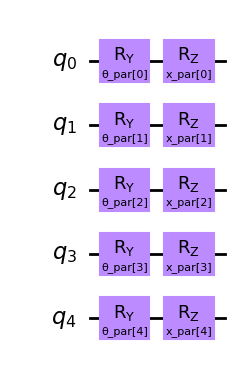

In [17]:
from qiskit.circuit import ParameterVector
from qiskit import QuantumCircuit
# Create 5-qubit feature map
qc = QuantumCircuit(5)

# Vectors of input and trainable user parameters
input_params = ParameterVector("x_par", 5)
training_params = ParameterVector("θ_par", 5)

# Create an initial rotation layer of trainable parameters
for i, param in enumerate(training_params):
    qc.ry(param, qc.qubits[i])

# Create a rotation layer of input parameters
for i, param in enumerate(input_params):
    qc.rz(param, qc.qubits[i])

qc.draw("mpl", style="clifford")

In [26]:
qkernel = TrainableFidelityQuantumKernel(feature_map=qc,training_parameters=training_params)

In [23]:
qkernel = FidelityQuantumKernel(feature_map=feature_map)

In [27]:
from qiskit_machine_learning.algorithms import PegasosQSVC

pegasos_qsvc = PegasosQSVC(quantum_kernel=qkernel, C=C, num_steps=tau)

# training
pegasos_qsvc.fit(train_features, train_labels)

# testing
pegasos_score = pegasos_qsvc.score(test_features, test_labels)
print(f"PegasosQSVC classification test score: {pegasos_score}")

QiskitMachineLearningError: 'Trainable parameter θ_par[0] has not been bound. Make sure to bind alltrainable parameters to numerical values using `.assign_training_parameters()`before calling `.evaluate()`.'

## Use QNN 
design a qnn circuit, which use 2 qubits, 4 inputs and 4 weights

input parameters: ['input[0]', 'input[1]', 'input[2]', 'input[3]', 'input[4]']
weight parameters: ['weight[0]', 'weight[1]', 'weight[2]', 'weight[3]', 'weight[4]', 'weight[5]', 'weight[6]', 'weight[7]', 'weight[8]', 'weight[9]']


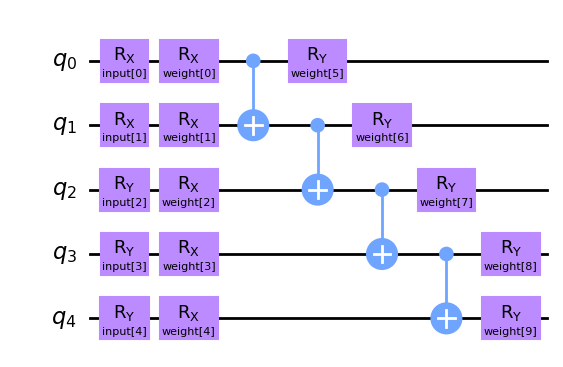

In [151]:
from qiskit.circuit import ParameterVector
from qiskit import QuantumCircuit

inputs = ParameterVector("input", 5)
weights = ParameterVector("weight", 10)
print(f"input parameters: {[str(item) for item in inputs.params]}")
print(f"weight parameters: {[str(item) for item in weights.params]}")

qc = QuantumCircuit(5)
qc.rx(inputs[0], 0)
qc.rx(inputs[1], 1)
qc.ry(inputs[2], 2)
qc.ry(inputs[3], 3)
qc.ry(inputs[4], 4)

qc.rx(weights[0], 0)
qc.rx(weights[1], 1)
qc.rx(weights[2], 2)
qc.rx(weights[3], 3)
qc.rx(weights[4], 4)

qc.cx(0, 1)
qc.cx(1, 2)
qc.cx(2, 3)
qc.cx(3, 4)

qc.ry(weights[5], 0)
qc.ry(weights[6], 1)
qc.ry(weights[7], 2)
qc.ry(weights[8], 3)
qc.ry(weights[9], 4)
qc.draw("mpl", style="clifford")

Use a callback function to draw a histogram

In [152]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

Define interpret function to map 4 outputs into 3 categories. Instantiate samplerQNN and NeutralNetworkClassifier.

In [153]:
import time
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_algorithms.optimizers import GradientDescent
from qiskit_machine_learning.utils.loss_functions import CrossEntropyLoss
from qiskit_algorithms.optimizers import COBYLA
from qiskit_machine_learning.algorithms import NeuralNetworkClassifier
import numpy as np
import random
from sklearn.preprocessing import OneHotEncoder

parity = lambda x: "{:b}".format(x).count("1") % 2 
output_shape = 2  # 0, 1, 2 one-hot encoding


optimizer = COBYLA(maxiter=40)
sampler_qnn = SamplerQNN(
    circuit=qc,
    input_params=inputs,
    weight_params=weights,
    interpret=parity,
    output_shape=output_shape,
)

qnn = NeuralNetworkClassifier(
    sampler_qnn, 
    loss='squared_error', 
    one_hot=True, 
    optimizer=optimizer, 
    warm_start=True, 
    initial_point=None, 
    callback=callback_graph
    )


# clear objective value history
objective_func_vals = []


### Train QNN without bandit and FL

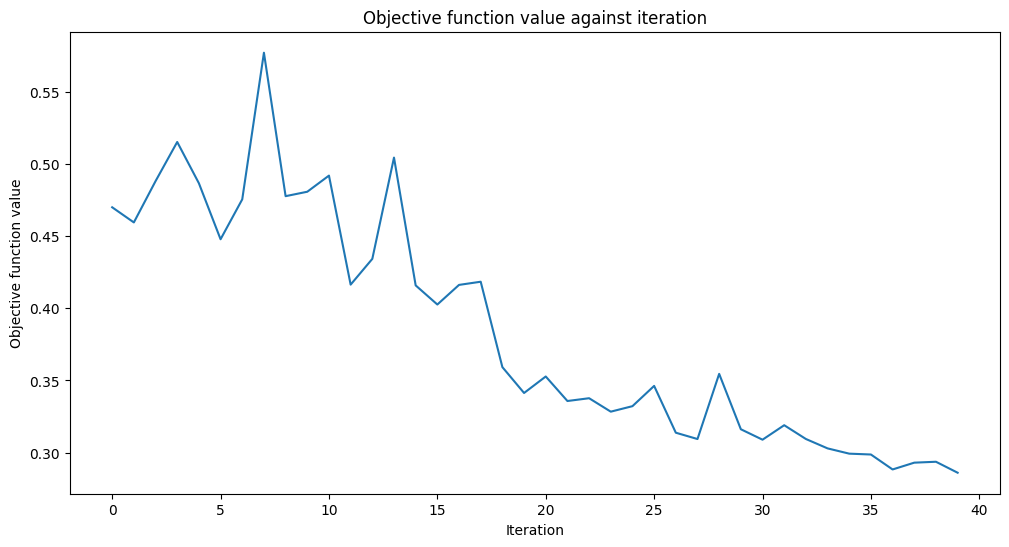

Training time: 3704 seconds
0.9541333333333334
Precision: 1.00
Recall: 0.91
Quantum QNN on the training dataset: 0.95
Quantum QNN on the test dataset:     0.95


In [154]:
from sklearn.metrics import precision_score, recall_score

start = time.time()
qnn.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

print(qnn.score(test_features, test_labels, sample_weight=None))

train_score_q4 = qnn.score(train_features, train_labels)
test_score_q4 = qnn.score(test_features, test_labels)
pred_labels = qnn.predict(test_features)
assert test_labels.ndim == 1, "test_labels should be a 1D array"
precision = precision_score(test_labels, pred_labels)
print(f'Precision: {precision:.2f}')
recall = recall_score(test_labels, pred_labels)
print(f'Recall: {recall:.2f}')

print(f"Quantum QNN on the training dataset: {train_score_q4:.2f}")
print(f"Quantum QNN on the test dataset:     {test_score_q4:.2f}")

## Environment Model: generating bandit data
Unlike before, we add an exploration module to this model. In the process of deploying the model, when the user uses the model, the model does not necessarily give the predicted label, but there is a certain probability that the model will give the user other labels. Generate a feedback record of whether the user approved of the tag. This feedback record includes input features, predicted labels, selected labels, and exploration probabilities.

The model starts with initial weights and is already ready to make predictions. Based on the input, it will produce a predicted output. Store the results of this model. During the midway process, the model can be optimized. The bandit algorithm is used to dynamically optimize the QFL model and explore the needs of users. The needs of users themselves will also change.

In [121]:
import random
import collections
import tensorflow as tf

### Epsilon Greedy

In [122]:
def epsilon_greedy_bandit_data(data,model,epsilon):
    train_sequences = [data_point["sequence"] for data_point in data]
    train_labels = [data_point["label"] for data_point in data]
    # Convert the lists to NumPy arrays
    train_sequences = np.array(train_sequences)
    train_labels = np.array(train_labels)

    arms_num = 2
    #模型预测值
    pred_action = model.predict(train_sequences)
    # get predicted vector in logits way
    logits = sampler_qnn.forward(train_sequences, model.weights)
    action_list = []
    reward_list = []
    prob_list = []
    arr = [0,1]
    print("Inference Started")
    for i in range(len(pred_action)):
        t =  random.random()
        if t < epsilon:
            remaining_action = [x for x in arr if x != pred_action[i]]
            action = random.choice(remaining_action)
            #print(action)
        else:
            action = pred_action[i]
            #print(action)
        action_list.append(action)

        if action == train_labels[i]:
            reward = 1
        else:
            reward = 0
        reward_list.append(reward)

        action_match_pred = (action_list[i]==pred_action[i])
        per_action_epsilon = epsilon / tf.cast(arms_num, dtype=tf.float32)
        prob = (1 - epsilon + per_action_epsilon) * action_match_pred + (
          1.0 - action_match_pred) * per_action_epsilon
        prob_list.append(prob)
    print("Inference Completed")
    
    action_logits = tf.gather(logits, action_list, axis=1, batch_dims=1).numpy()
    weight_scale = tf.math.minimum(
          1 - epsilon + per_action_epsilon, per_action_epsilon
      )
    new_y = collections.OrderedDict([
          ('label', pred_action),
          ('action', action_list),
          ('reward', reward_list),
          ('prob', prob_list),
          ('logits', action_logits),
          ('weight_scale', weight_scale),
      ])
    bandits_data = collections.OrderedDict(x=train_sequences, y=new_y)
    
    return bandits_data

    
#bandits_data = epsilon_greedy_bandit_data(qnn,0.2)
#print(bandits_data)




### Falcon

In [140]:
def falcon_bandit_data(data,model,mu,gamma):
  train_sequences = [data_point["sequence"] for data_point in data]
  train_labels = [data_point["label"] for data_point in data]
  # Convert the lists to NumPy arrays
  train_sequences = np.array(train_sequences)
  train_labels = np.array(train_labels)

  pred_action = model.predict(train_sequences)
  pred_logits = sampler_qnn.forward(train_sequences, model.weights)
  #print("pred_logits:",pred_logits)
  batch_size = tf.shape(pred_logits)[0]
  num_arms = tf.shape(pred_logits)[1]
  greedy_action = tf.argmax(pred_logits, axis=1, output_type=tf.int32)
  #print("greedy_action:",greedy_action)
  greedy_logits = tf.gather(pred_logits, greedy_action, axis=1, batch_dims=1)
  #print("greedy_logits:",greedy_logits)
  nongreedy_res = tf.expand_dims(greedy_logits, axis=1) - pred_logits
  #print("nongreedy_res:",nongreedy_res)
  nongreedy_prob = 1.0 / (mu + gamma * nongreedy_res)
  #print("nongreedy_prob:",nongreedy_prob)
  greedy_indicator = tf.one_hot(
      greedy_action, depth=num_arms, on_value=True, off_value=False
  )
  #print("greedy_indicator",greedy_indicator)
  nongreedy_prob = tf.where(
      greedy_indicator, tf.zeros_like(pred_logits), nongreedy_prob
  )
  #print("nongreedy_prob",nongreedy_prob)
  # Normalize nongreedy_prob if the sum of probablility is larger than 1 so that
  # it is still a probability distribution to be sampled even if mu and gamma
  # are not properly set.
  nongreedy_prob = nongreedy_prob / tf.math.maximum(
      1.0, tf.math.reduce_sum(nongreedy_prob, axis=1, keepdims=True)
  )
  greedy_prob = 1.0 - tf.math.reduce_sum(nongreedy_prob, axis=1)
  greedy_idx = tf.stack([tf.range(batch_size), greedy_action], axis=1)
  prob = (
      tf.scatter_nd(greedy_idx, greedy_prob, shape=tf.shape(pred_logits))
      + nongreedy_prob
  )
  cumsum_prob = tf.math.cumsum(prob, axis=1)
  cumsum_prob = tf.cast(cumsum_prob, dtype=tf.float32)
  # We can use tf.random.uniform for independent noise on clients, see
  # https://www.tensorflow.org/federated/tutorials/random_noise_generation
  random_val = tf.random.uniform(
      shape=[batch_size], minval=0, maxval=1, dtype=tf.float32
  )
  less_idx = tf.math.less(tf.expand_dims(random_val, axis=1), cumsum_prob)
  # The `action_helper` is constructed so that if the `cumsum_prob` is larger
  # than or equal to `random_val`, the values are the action index; if
  # `cumsum_prob` is smaller, the values are a constant number of the largest
  # possible index of action. When taking the min of `action_helper`,
  # the action where random_val falls in the `cumsum_prob` backet is returned;
  # i.e., the action is sampled based on the falcon `prob`.
  action_helper = tf.where(
      less_idx,
      tf.broadcast_to(
          tf.range(num_arms, dtype=tf.int32), shape=[batch_size, num_arms]
      ),
      (num_arms - 1) * tf.ones(shape=(batch_size, num_arms), dtype=tf.int32),
  )

  # bandit data
  action = tf.math.reduce_min(action_helper, axis=1).numpy()
  print("action:", action)
  action_prob = tf.gather(prob, action, axis=1, batch_dims=1).numpy()
  action_logits = tf.gather(pred_logits, action, axis=1, batch_dims=1).numpy()
  reward_list = []
  for i in range(batch_size):
    if action[i] == train_labels[i]:
        reward = 1
    else:
        reward = 0
    reward_list.append(reward)
  #print("reward:",reward_list)
  weight_scale = 1.0 / (mu + gamma)
  new_y = collections.OrderedDict([
          ('label', pred_action),#predicted action
          ('action', action),#actual action
          ('reward', reward_list),#comparation between correct action(test_label) and actual action
          ('prob', action_prob),
          ('logits', action_logits),
          ('weight_scale', weight_scale),
      ])
  return collections.OrderedDict(x=train_sequences, y=new_y)


bandits_data = falcon_bandit_data(train_set,qnn,0.5,10)
print("----------------------------------------------------------------------")
print(bandits_data['y']['logits'])


action: [0 0 0 ... 0 0 1]
----------------------------------------------------------------------
[0.46902281 0.56420502 0.49417341 ... 0.89369568 0.73165556 0.24093395]


### Softmax Sampling

In [124]:
def softmax_sampling_bandit_data(data,model,temperature):
    train_sequences = [data_point["sequence"] for data_point in data]
    train_labels = [data_point["label"] for data_point in data]
    # Convert the lists to NumPy arrays
    train_sequences = np.array(train_sequences)
    train_labels = np.array(train_labels)

    pred_action = model.predict(train_sequences)
    pred_logits = sampler_qnn.forward(train_sequences, model.weights)
    batch_size = tf.shape(pred_logits)[0]
    num_arms = tf.shape(pred_logits)[1]
    prob = tf.keras.activations.softmax(pred_logits/temperature, axis=-1)
    cumsum_prob = tf.math.cumsum(prob, axis=1)
    cumsum_prob = tf.cast(cumsum_prob, dtype=tf.float32)
    # We can use tf.random.uniform for independent noise on clients, see
    # https://www.tensorflow.org/federated/tutorials/random_noise_generation
    random_val = tf.random.uniform(
        shape=[batch_size], minval=0, maxval=1, dtype=tf.float32
    )
    less_idx = tf.math.less(tf.expand_dims(random_val, axis=1), cumsum_prob)
    # The `action_helper` is constructed so that if the `cumsum_prob` is larger
    # than or equal to `random_val`, the values are the action index; if
    # `cumsum_prob` is smaller, the values are a constant number of the largest
    # possible index of action. When taking the min of `action_helper`,
    # the action where random_val falls in the `cumsum_prob` backet is returned;
    # i.e., the action is sampled based on the softmax `prob`.
    action_helper = tf.where(
        less_idx,
        tf.broadcast_to(
            tf.range(num_arms, dtype=tf.int32), shape=[batch_size, num_arms]
        ),
        (num_arms - 1) * tf.ones(shape=(batch_size, num_arms), dtype=tf.int32),
    )
    action = tf.math.reduce_min(action_helper, axis=1).numpy()
    print("action:", action)
    action_prob = tf.gather(prob, action, axis=1, batch_dims=1).numpy()
    action_logits = tf.gather(pred_logits, action, axis=1, batch_dims=1).numpy()
    reward_list = []
    for i in range(batch_size):
        if action[i] == train_labels[i]:
            reward = 1
        else:
            reward = 0
        reward_list.append(reward)
    #print("reward:",reward_list)
    weight_scale = 1.0 
    new_y = collections.OrderedDict([
          ('label', pred_action),#predicted action
          ('action', action),#actual action
          ('reward', reward_list),#comparation between correct action(test_label) and actual action
          ('prob', action_prob),
          ('logits', action_logits),
          ('weight_scale', weight_scale),
      ])
    return collections.OrderedDict(x=train_sequences, y=new_y)


#bandits_data = softmax_sampling_bandit_data(qnn,0.05)
#print("----------------------------------------------------------------------")
#print(bandits_data)


## Implementing the Bandit in QNN
Use bandit data to train the QNN. Mainly change the loss function.

### Loss function with weights

In [125]:

from qiskit_machine_learning.utils.loss_functions import CrossEntropyLoss,L2Loss,Loss
from qiskit_machine_learning.exceptions import QiskitMachineLearningError
class L1Loss_w():
    r"""
    This class computes the L1 loss (i.e. absolute error) for each sample as:

    .. math::

        \text{L1Loss}(predict, target) = \sum_{i=0}^{N_{\text{elements}}} \left| predict_i -
        target_i \right|.
    """
    def __call__(self, predict: np.ndarray, target: np.ndarray,weights: np.ndarray = None) -> np.ndarray:
        """
        This method calls the ``evaluate`` method. This is a convenient method to compute loss.
        """
        return self.evaluate(predict, target)

    def evaluate(self, predict: np.ndarray, target: np.ndarray,weights: np.ndarray = None) -> np.ndarray:
        self._validate_shapes(predict, target)
        if weights is None:
            if len(predict.shape) <= 1:
                return np.abs(predict - target)
            else:
                return np.linalg.norm(predict - target, ord=1, axis=tuple(range(1, len(predict.shape))))
        else:
            if len(predict.shape) <= 1:
                return np.abs(predict - target)*weights
            else:
                return np.linalg.norm(predict - target, ord=1, axis=tuple(range(1, len(predict.shape))))*weights

    def gradient(self, predict: np.ndarray, target: np.ndarray) -> np.ndarray:
        self._validate_shapes(predict, target)

        return np.sign(predict - target)
    @staticmethod
    def _validate_shapes(predict: np.ndarray, target: np.ndarray) -> None:
        """
        Validates that shapes of both parameters are identical.

        Args:
            predict: an array of predicted values using the model
            target: an array of the true values

        Raises:
            QiskitMachineLearningError: shapes of predict and target do not match.
        """

        if predict.shape != target.shape:
            raise QiskitMachineLearningError(
                f"Shapes don't match, predict: {predict.shape}, target: {target.shape}!"
            )

### Bandit Process

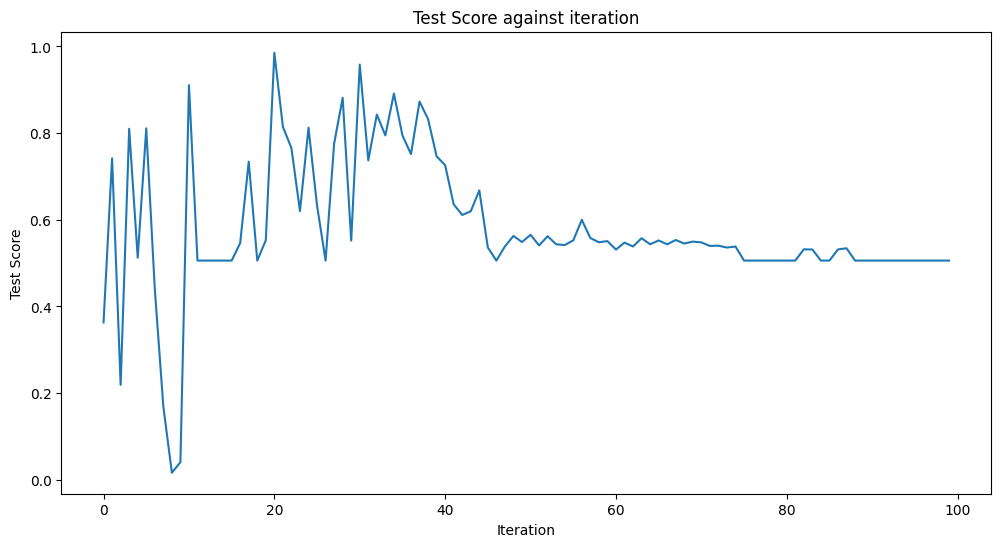

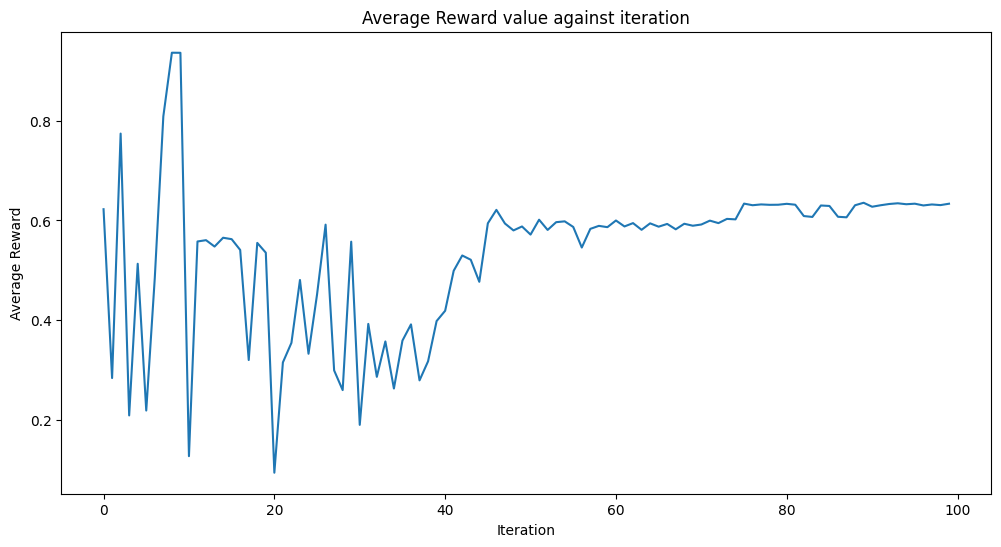

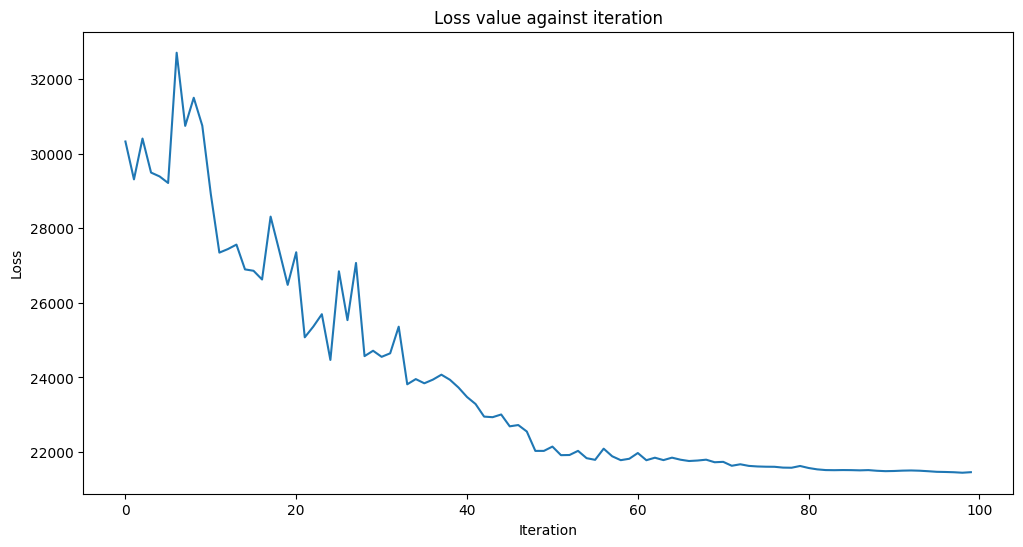

[ -48.0738377    30.41316211   34.86002227    9.0199725   -77.79904441
   -6.23837788   40.79705315   24.20303318 -102.40684592  136.76381528]
Precision: 0.51
Recall: 1.00


In [164]:
import time
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_algorithms.optimizers import GradientDescent
from qiskit_algorithms.optimizers import COBYLA
from qiskit_machine_learning.algorithms import NeuralNetworkClassifier
import numpy as np
scoreList = []
rewardList = []
lossList = []
def callback_bandit(score,reward,loss):
    clear_output(wait=True)
    scoreList.append(score)
    plt.title("Test Score against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Test Score")
    plt.plot(range(len(scoreList)), scoreList)
    plt.show()

    rewardList.append(reward)
    plt.title("Average Reward value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Average Reward")
    plt.plot(range(len(rewardList)), rewardList)
    plt.show()

    lossList.append(loss)
    plt.title("Loss value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.plot(range(len(lossList)), lossList)
    plt.show()
    


def banditLoss(weights):
    qnn.fit_result.x = weights
    # epsilon greedy
    #bandits_data = epsilon_greedy_bandit_data(train_set,qnn,0.35)
    # falcon
    bandits_data = falcon_bandit_data(train_set,qnn,1,1)
    # softmax sampling
    #bandits_data = softmax_sampling_bandit_data(train_set,qnn,0.05)
    
    logits = np.array(bandits_data['y']['logits'])
    reward = np.array(bandits_data['y']['reward'])
    sum_reward=float(sum(reward))
    prob = np.array(bandits_data['y']['prob'])
    weight_scale = np.array(bandits_data['y']['weight_scale'])
    sample_weights =  weight_scale / prob
    #label = np.array(bandits_data['y']['label'])

    #cross entropy loss
    #loss_function = CrossEntropyLoss()
    #loss = loss_function(logits, reward)
    #loss_item = float(np.squeeze(loss))
    #print("Loss:", loss_item)

    #squared error
    #loss_function = L2Loss()
    #loss = loss_function(logits, reward)
    #loss_item = sum(loss)
    #print("Loss:", loss_item)

    #squared error
    loss_function = L1Loss_w()
    loss = loss_function(logits,reward,sample_weights)
    loss_item = sum(loss)
    print("Loss_5:", loss_item)
    print("logits:",logits)
    print("reward_avg:",sum(reward)/len(reward))
    
    print("Score:", qnn.score(test_features, test_labels))
    print("sum_reward:",sum_reward)
    #print(qnn.fit_result.x)
    #print(qnn.weights)
    score = qnn.score(test_features, test_labels)
    precision = precision_score(test_labels, pred_labels)
    print(f'Precision: {precision:.2f}')
    recall = recall_score(test_labels, pred_labels)
    print(f'Recall: {recall:.2f}')
    avg_reward = sum_reward/len(reward)
    #callback_bandit(score)
    callback_bandit(score,avg_reward,loss_item)
    return loss_item

#optimizer = GradientDescent(maxiter=100, learning_rate=0.01)
optimizer = COBYLA(maxiter=100)
fit_result = optimizer.minimize(fun=banditLoss, x0=qnn.weights)
#qnn.initial_point = weights['x']
#print(qnn.fit_result.x)
#print("result:", k)
qnn.fit_result.x = fit_result.x
print(qnn.weights)
pred_labels = qnn.predict(test_features)
assert test_labels.ndim == 1, "test_labels should be a 1D array"
precision = precision_score(test_labels, pred_labels)
print(f'Precision: {precision:.2f}')
recall = recall_score(test_labels, pred_labels)
print(f'Recall: {recall:.2f}')




In [159]:
pred_labels = qnn.predict(test_features)
precision = precision_score(test_labels, pred_labels)
print(f'Precision: {precision:.2f}')
recall = recall_score(test_labels, pred_labels)
print(f'Recall: {recall:.2f}')

Precision: 0.00
Recall: 0.00


In [160]:
print(qnn.score(test_features, test_labels, sample_weight=None))

train_score_q4 = qnn.score(train_features, train_labels)
test_score_q4 = qnn.score(test_features, test_labels)

print(f"Quantum QNN on the training dataset: {train_score_q4:.2f}")
print(f"Quantum QNN on the test dataset:     {test_score_q4:.2f}")

print(qnn.weights)

0.3584
Quantum QNN on the training dataset: 0.36
Quantum QNN on the test dataset:     0.36
[ -49.63731672   29.98936409   35.85859387    9.92358769  -79.94350423
   -4.78899679   40.99771457   24.64619047 -102.00617248  136.56924757]


## Configuring the Federated Learning Setup

In this code section, we establish essential variables and settings for our Federated Learning setup. These variables play a crucial role in shaping how the Federated Learning process unfolds and offer the flexibility to customize the experiment to meet specific requirements.

Here, we outline the key variables that we define:

- `num_clients`: This variable determines the number of participating clients in our Federated Learning setup. Each client plays a role in the learning process.
- `num_epochs`: It specifies the number of training epochs, indicating how many times the Federated Learning process will iterate through the training data for each client.
- `max_train_iterations`: This variable controls the maximum number of training iterations that each client will perform during each round of Federated Learning.
- `samples_per_epoch`: It defines the number of samples processed in each training epoch for each client.
- `backend`: The choice of backend, specified as 'aer_simulator' in this code, determines the quantum simulator used for the Federated Learning setup. If you intend to work with a real quantum device, you can replace this backend with a real quantum device backend provided by IBM Quantum.

It's important to note that you can adjust these values as needed, depending on your specific use case and testing requirements. However, there is a critical constraint to consider: Ensure that the size of the `np_train_data` dataset is less than or equal to the product of `num_clients`, `num_epochs`, and `samples_per_epoch`. This constraint ensures that there is sufficient data to split between each client.


In [162]:
num_clients = 3
num_epochs = 25
max_train_iterations = 25
samples_per_epoch= 100

pretrain_itr = 0


#print(np_data_set)


class Client:
    def __init__(self, data):
        self.models = []
        self.primary_model = None
        self.data = data
        self.test_scores = []
        self.train_scores = []
        self.avg_reward = []

def split_dataset(num_clients, num_epochs, samples_per_epoch):
  clients = []
  for i in range(num_clients):
    client_data = []
    for j in range(num_epochs):
      start_idx = (i*num_epochs*samples_per_epoch)+(j*samples_per_epoch)
      end_idx = (i*num_epochs*samples_per_epoch)+((j+1)*samples_per_epoch)
      #print(start_idx, end_idx)
      client_data.append(train_set[start_idx:end_idx])
    clients.append(Client(client_data))
  return clients

clients = split_dataset(num_clients, num_epochs, samples_per_epoch)
print(clients[2].data)



[[{'sequence': array([0.35199989, 0.35199989, 0.35199673, 0.35199673, 0.35199673]), 'label': 0}, {'sequence': array([0.35643049, 0.35643049, 0.35642729, 0.35642729, 0.35642729]), 'label': 0}, {'sequence': array([0.97103344, 0.97103344, 0.97102471, 0.97102471, 0.97102471]), 'label': 1}, {'sequence': array([0.94414593, 0.94414593, 0.94413745, 0.94413745, 0.94413745]), 'label': 1}, {'sequence': array([0.09361458, 0.09361458, 0.09361374, 0.09361374, 0.09361374]), 'label': 0}, {'sequence': array([0.49445134, 0.49445134, 0.4944469 , 0.4944469 , 0.4944469 ]), 'label': 1}, {'sequence': array([0.6404019 , 0.6404019 , 0.64039615, 0.64039615, 0.64039615]), 'label': 1}, {'sequence': array([0.22507722, 0.22507722, 0.22507519, 0.22507519, 0.22507519]), 'label': 0}, {'sequence': array([0.89390611, 0.89390611, 0.89389808, 0.89389808, 0.89389808]), 'label': 1}, {'sequence': array([0.59025905, 0.59025905, 0.59025374, 0.59025374, 0.59025374]), 'label': 1}, {'sequence': array([0.84807899, 0.84807899, 0.84

## Training Function

In [134]:
import time

itr = 0  
def callback_itr(weights, obj_func_eval):
    global itr
    itr += 1
    print(f"{itr}", end=' | ')
    

def train(data, model = None):
  train_sequences = [data_point["sequence"] for data_point in data]
  train_labels = [data_point["label"] for data_point in data]
  # Convert the lists to NumPy arrays
  train_sequences = np.array(train_sequences)
  train_labels = np.array(train_labels)

  # Print the shapes
  print("Train Sequences Shape:", train_sequences.shape)
  print("Train Labels Shape:", train_labels.shape)


  if model is None:
    #optimizer = COBYLA(maxiter=max_train_iterations)
    optimizer = COBYLA(maxiter=pretrain_itr)
    sampler_qnn = SamplerQNN(
    circuit=qc,
    input_params=inputs,
    weight_params=weights,
    interpret=parity,
    output_shape=output_shape,
    )
    qnn = NeuralNetworkClassifier(
        sampler_qnn, 
        loss='squared_error', 
        one_hot=True, 
        optimizer=optimizer, 
        warm_start=True, 
        initial_point=None, 
        #callback=callback_graph
    )
    model = qnn
    #model.fit_result.x = [0.91698094, 3.82355225, 0.62690029, 1.53121652]

  
  def clientBanditLoss(weights):
    model.fit_result.x = weights
    # epsilon greedy
    #bandits_data = epsilon_greedy_bandit_data(qnn,0.05)
    # falcon
    bandits_data = falcon_bandit_data(data,model,12,1000)
    # softmax sampling
    #bandits_data = softmax_sampling_bandit_data(qnn,0.05)
    
    logits = np.array(bandits_data['y']['logits'])
    reward = np.array(bandits_data['y']['reward'])
    sum_reward=float(sum(reward))
    prob = np.array(bandits_data['y']['prob'])
    weight_scale = np.array(bandits_data['y']['weight_scale'])
    sample_weights =  weight_scale / prob
   
    loss_function = L1Loss_w()
    loss = loss_function(logits,reward,sample_weights)
    loss_item = sum(loss)
    print("Loss_5:", loss_item)
    print("sum_reward:",sum_reward)
    print("reward_avg:",sum(reward)/len(reward))
    print("Score:", model.score(test_features, test_labels))


    return loss_item

  print("Training Started")
  start_time = time.time()
  model.fit(train_sequences, train_labels)
  optimizer = COBYLA(maxiter=max_train_iterations)
  #optimizer = GradientDescent(maxiter=max_train_iterations, learning_rate=0.001)
  fit_result = optimizer.minimize(fun=clientBanditLoss, x0=model.weights)
  model.fit_result.x = fit_result.x
  end_time = time.time()
  elapsed_time = end_time - start_time
  print(f"\nTraining complete. Time taken: {elapsed_time} seconds.")

  print(f"SCORING MODEL")
  train_score_q = model.score(train_sequences, train_labels)
  test_score_q = model.score(test_features, test_labels)
  return train_score_q, test_score_q, model



## Model Accuracy and Creation Functions

In the provided code, two essential functions are defined, each with a specific role.

**`getAccuracy` Function**:
- The `getAccuracy` function calculates and returns the accuracy of a model with given weights. It initializes a Quantum Variational Circuit (QVC) model with the provided weights and prepares it for evaluation. While it includes a call to the training function (`vqc.fit()`), the training itself doesn't occur because we set the maximum iteration value of the optimizer to 0. This is done as a workaround because we cannot directly use the `.score` function without first executing the `.fit` function on a new VQC class instance. After model preparation, the function computes the accuracy by evaluating the model's performance using test sequences and labels.

**`create_model_with_weights` Function**:
- The `create_model_with_weights` function creates a new Quantum Variational Circuit (QVC) model with an initial point set to the given weights. This function is instrumental in creating a global model from global model weights during the Federated Learning training process.


In [135]:
from functools import partial
def getAccuracy(weights):
    optimizer = COBYLA(maxiter=0)
    qnn = NeuralNetworkClassifier(
        sampler_qnn, 
        loss='squared_error', 
        one_hot=True, 
        optimizer=optimizer, 
        warm_start=True, 
        initial_point=weights, 
    )
    qnn.fit(test_features[:25], test_labels[:25])
    return qnn.score(test_features, test_labels)

def getAvgReward(weights):
    optimizer = COBYLA(maxiter=0)
    qnn = NeuralNetworkClassifier(
        sampler_qnn, 
        loss='squared_error', 
        one_hot=True, 
        optimizer=optimizer, 
        warm_start=True, 
        initial_point=weights, 
    )
    qnn.fit(test_features[:25], test_labels[:25])
    qnn.fit_result.x=weights
    bandits_data = falcon_bandit_data(test_set,qnn,12,1000)
    # softmax sampling
    #bandits_data = softmax_sampling_bandit_data(qnn,0.05)
    reward = np.array(bandits_data['y']['reward'])
    sum_reward=float(sum(reward))
    avg_reward=sum_reward/len(reward)
    return avg_reward

def create_model_with_weights(weights):
    optimizer = COBYLA(maxiter=max_train_iterations)
    qnn = NeuralNetworkClassifier(
        sampler_qnn, 
        loss='squared_error', 
        one_hot=True, 
        optimizer=optimizer, 
        warm_start=True, 
        initial_point=weights, 
        #callback=partial(callback_itr)
    )
    #qnn.fit(test_features, test_labels)
    return qnn

In [136]:
import warnings

# Temporary code to suppress all FutureWarnings for a cleaner output
warnings.simplefilter("ignore", FutureWarning)

## Federated Learning Training Loop

In this code, we implement the training loop for Federated Learning across multiple epochs and clients. The key steps and processes are as follows:

1. **Epoch-by-Epoch Training**: The code iterates through each epoch, starting with epoch 0, and prepares to train client models for that epoch.

2. **Client Training**: For each epoch, the code goes through all the clients, one by one. It checks if the client has a primary model. If not, it creates a new model and trains the model using the training data specific to that client and epoch. The resulting model is stored in the client's `models` array. The training process also calculates and stores the training and testing scores for each client.

3. **Global Model Aggregation**: After training the models for all clients in a given epoch, the code collects the trained model weights in an array called `epoch_weights`. This array holds the weights of all client models and the global model from the previous epoch (if applicable).

4. **Global Model Averaging**: The code computes the average of the weights in the `epoch_weights` array to create a global model for that epoch. This global model represents a consensus model generated from the weighted combination of client models and the previous global model (if any).
 - To extend the

5. **Client Model Update**: The new global model is assigned to each client as its primary model for the next epoch. This ensures that all clients train using the same global model in the following epoch.

6. **Global Model Evaluation**: The code evaluates the accuracy of the global model on a subset of testing data. The accuracy is stored in the `global_model_accuracy` array for tracking the performance of the global model over different epochs.

The code proceeds to repeat this process for all specified epochs. This iterative training and global model update are essential for Federated Learning, allowing clients to contribute to the global model while maintaining their own local data privacy and model customization.


### Result Visualization: Accuracy and Average Reward

In [137]:
import matplotlib.pyplot as plt

def callback_results(clients, global_model_accuracy, global_model_avg_reward):
    # Create two figures, one for train scores and one for test scores
    plt.figure(figsize=(8, 6))

    # Plot train scores for all clients
    for client in clients:
        plt.plot(client.train_scores, label=f'Client {clients.index(client) + 1}')

    plt.xlabel('Epochs')
    plt.ylabel('Train Score')
    plt.title('Train Scores for All Clients')
    plt.legend()

    # Show the train scores plot
    plt.show()

    # Create a new figure for test scores
    plt.figure(figsize=(8, 6))

    # Plot test scores for all clients
    for client in clients:
        plt.plot(client.test_scores, label=f'Client {clients.index(client) + 1}')

    # Plot global model accuracy
    plt.plot(global_model_accuracy, label='Global Model Accuracy', linestyle='--', color='black')
    plt.xlabel('Epochs')
    plt.ylabel('Test Score')
    plt.title('Test Scores for All Clients')
    plt.legend()

    # Show the test scores plot
    plt.show()

   # Create a new figure for average reward
    plt.figure(figsize=(8, 6))
    # Plot average reward for all clients
    for client in clients:
        plt.plot(client.avg_reward, label=f'Client {clients.index(client) + 1}')
    # Plot global model accuracy
    plt.plot(global_model_avg_reward, label='Global Model Average Reward', linestyle='--', color='black')
    plt.xlabel('Epochs')
    plt.ylabel('Average Reward')
    plt.title('Average Reward for All Clients')
    plt.legend()

    # Show the test scores plot
    plt.show()

epoch: 0
Index: 0, Client: <__main__.Client object at 0x0000023426A059D0>
Train Sequences Shape: (100, 5)
Train Labels Shape: (100,)
Training Started
action: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Loss_5: 49.984207387298
sum_reward: 50.0
reward_avg: 0.5
Score: 0.4941333333333333
action: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Loss_5: 50.005485416646685
sum_reward: 49.0
reward_avg: 0.49
Score: 0.5058666666666667
action: [0 0 0 1 0 0 0 1 1 0 1 1 1 0 0 0 0 1 0 0 0 1 0 1 0 1 1 0 0 0 1 0 1 1 1 0 1
 0 1 0 0 0 1 1 0 1 0 1 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1
 0 0 0 0 1 0 1 0 1 1 1 1 1 1 1 0 0 0 1 0 0 0 1 0 0 0]
Loss_5: 54.29414613431526
sum_reward: 12.0
r

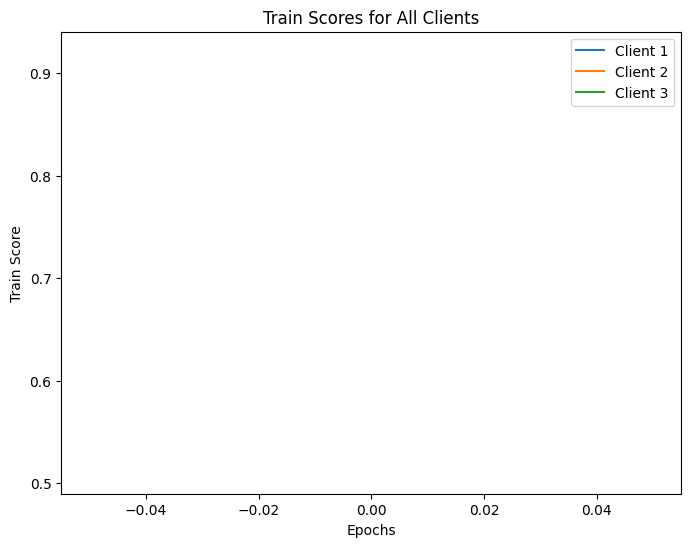

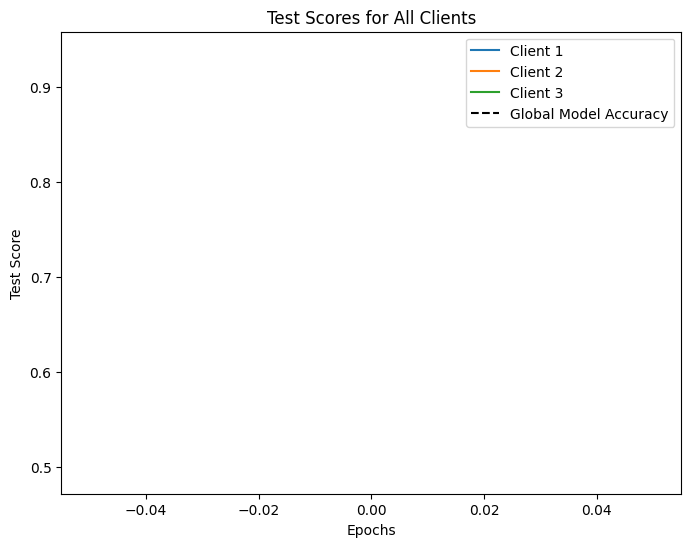

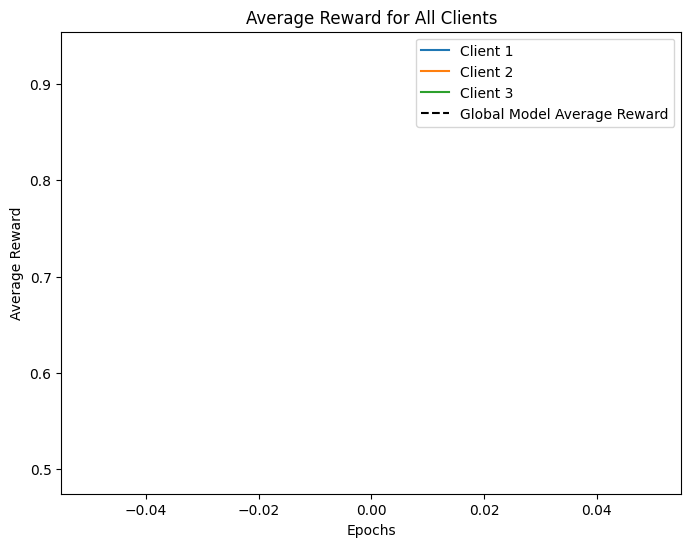

epoch: 1
Index: 0, Client: <__main__.Client object at 0x0000023426A059D0>
Train Sequences Shape: (100, 5)
Train Labels Shape: (100,)
Training Started
action: [0 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 0 1 0 1 0 1 0 0 0 1 0 1 0 0 1 1 1 0 0 0 1
 0 0 1 0 1 0 0 0 1 0 0 0 1 0 1 0 1 1 0 0 1 1 1 1 0 0 0 0 0 1 1 0 0 0 0 0 1
 0 0 0 1 1 1 1 0 1 1 0 1 1 0 1 1 1 0 0 0 0 1 1 0 1 0]
Loss_5: 36.80726557945385
sum_reward: 97.0
reward_avg: 0.97
Score: 0.9538
action: [0 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 0 1 0 1 0 1 0 0 0 1 0 1 0 0 1 1 1 0 0 0 1
 0 0 1 0 1 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 1 1 1 1 0 0 0 0 0 1 1 0 0 0 0 0 1
 0 0 0 1 1 1 1 0 1 1 0 1 1 0 1 1 0 0 0 0 0 1 1 0 1 0]
Loss_5: 42.69251529132425
sum_reward: 96.0
reward_avg: 0.96
Score: 0.9538
action: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Loss_5: 41.360224874716955
sum_reward: 52.0
reward_avg: 0.52
Score

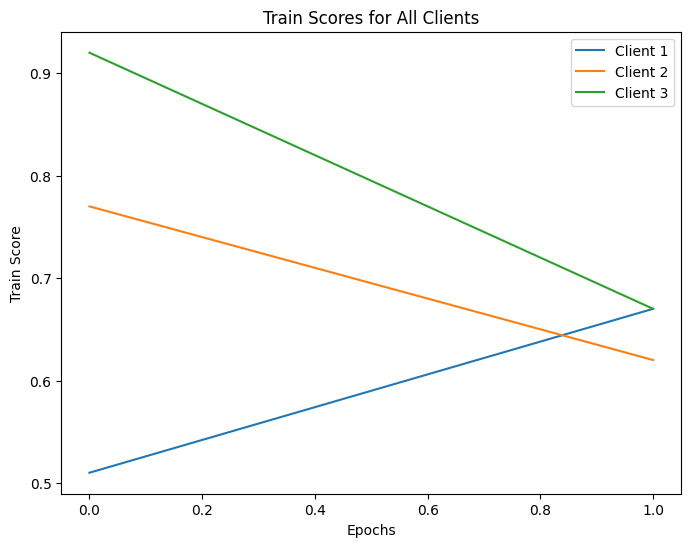

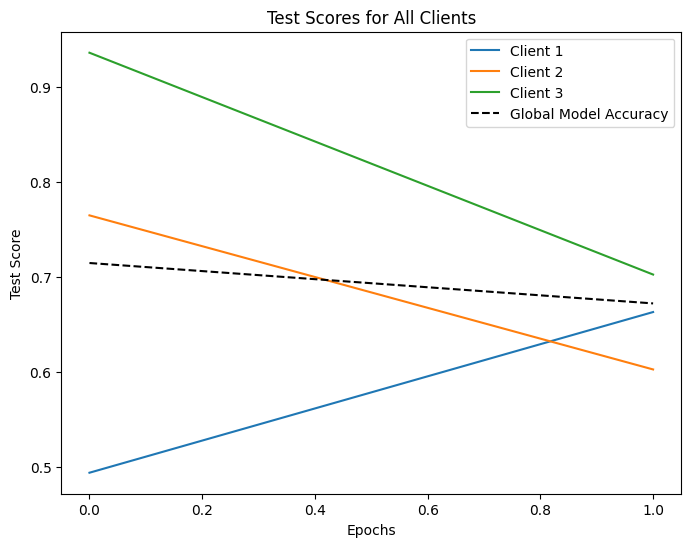

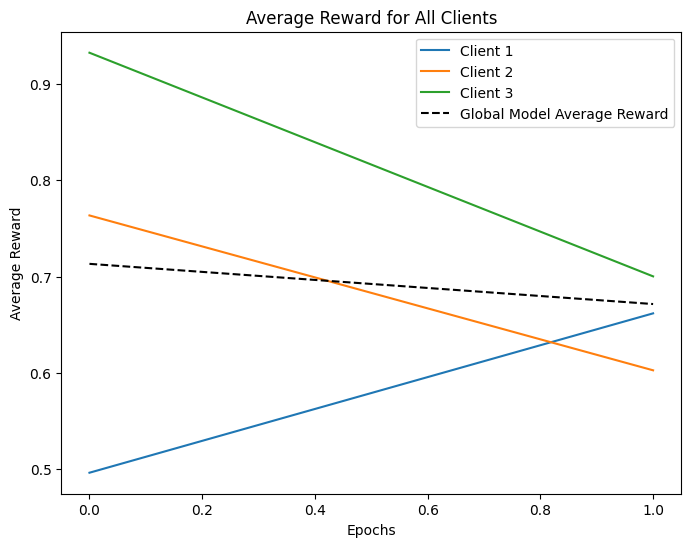

epoch: 2
Index: 0, Client: <__main__.Client object at 0x0000023426A059D0>
Train Sequences Shape: (100, 5)
Train Labels Shape: (100,)
Training Started
action: [1 0 0 0 0 1 1 0 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 1 1 1 0 0 0 0 1
 0 0 1 1 0 0 0 0 0 1 0 1 1 1 0 0 0 1 1 0 1 1 0 0 1 1 0 0 0 0 1 0 0 1 1 1 0
 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 1 1 0 0]
Loss_5: 36.51206694100048
sum_reward: 89.0
reward_avg: 0.89
Score: 0.922
action: [1 0 0 0 0 1 1 0 0 0 0 1 0 1 0 0 1 0 1 1 0 0 0 1 0 0 0 0 0 1 1 1 0 0 0 0 1
 0 0 1 1 0 0 0 0 0 1 0 1 1 1 0 0 0 1 1 0 1 1 0 0 1 1 0 0 0 0 1 0 0 1 1 1 0
 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 1 1 0 0]
Loss_5: 42.6548574206311
sum_reward: 90.0
reward_avg: 0.9
Score: 0.922
action: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Loss_5: 41.16822044443752
sum_reward: 54.0
reward_avg: 0.54
Score: 0.4

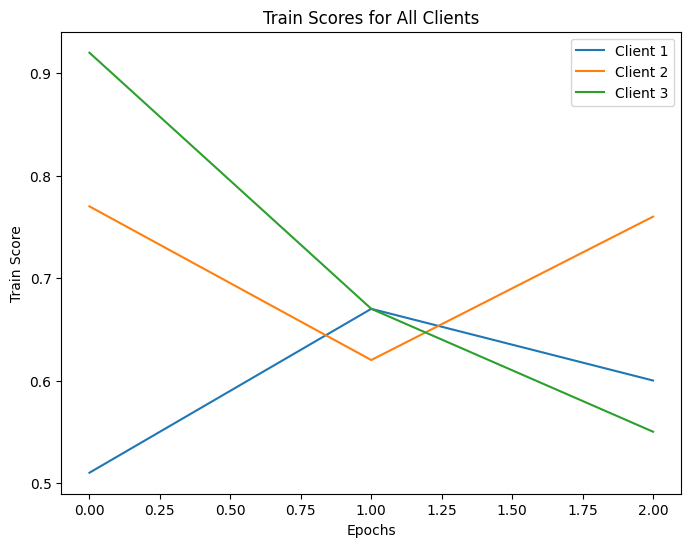

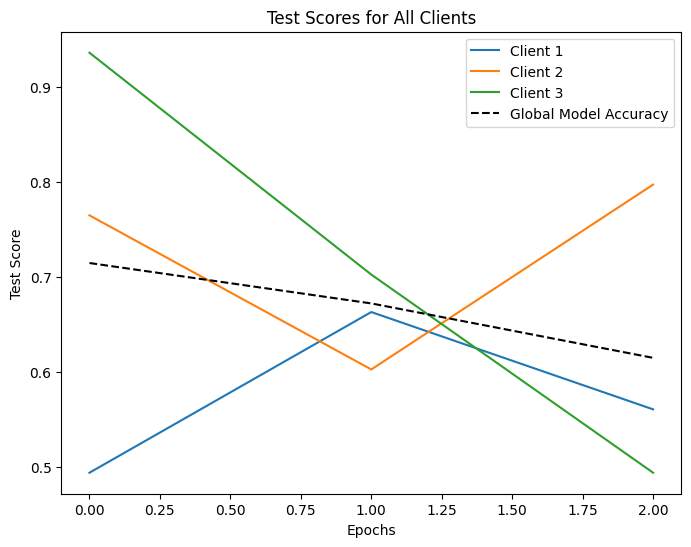

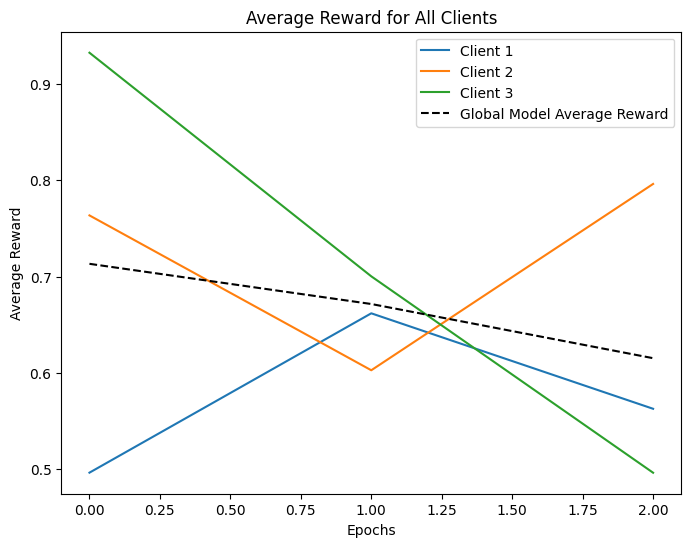

epoch: 3
Index: 0, Client: <__main__.Client object at 0x0000023426A059D0>
Train Sequences Shape: (100, 5)
Train Labels Shape: (100,)
Training Started
action: [0 1 1 0 0 0 0 1 1 0 1 0 1 0 0 1 1 0 1 0 0 1 0 0 1 1 1 0 1 1 1 0 1 0 0 1 0
 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 1 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 1 0
 1 1 1 0 0 1 0 1 1 0 1 0 0 1 1 1 0 1 0 0 0 1 1 0 0 0]
Loss_5: 37.0484477814046
sum_reward: 94.0
reward_avg: 0.94
Score: 0.9176666666666666
action: [0 1 1 0 0 0 0 1 1 0 1 0 1 0 0 1 1 0 1 0 0 1 0 0 1 1 1 0 1 1 1 0 1 0 0 1 0
 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 1 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 1 0
 1 1 1 0 0 1 0 1 1 0 1 0 0 1 1 1 0 1 0 0 0 1 1 0 0 0]
Loss_5: 43.32879768946852
sum_reward: 94.0
reward_avg: 0.94
Score: 0.9176666666666666
action: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
Loss_5: 41.71321890685123
sum_reward: 50.0


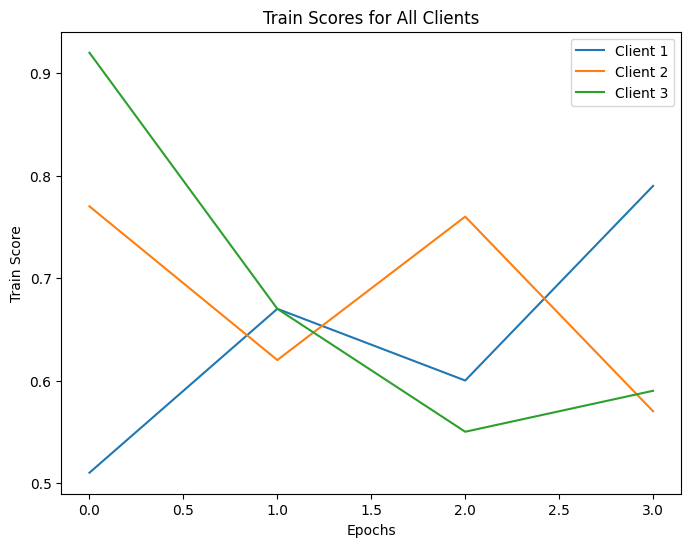

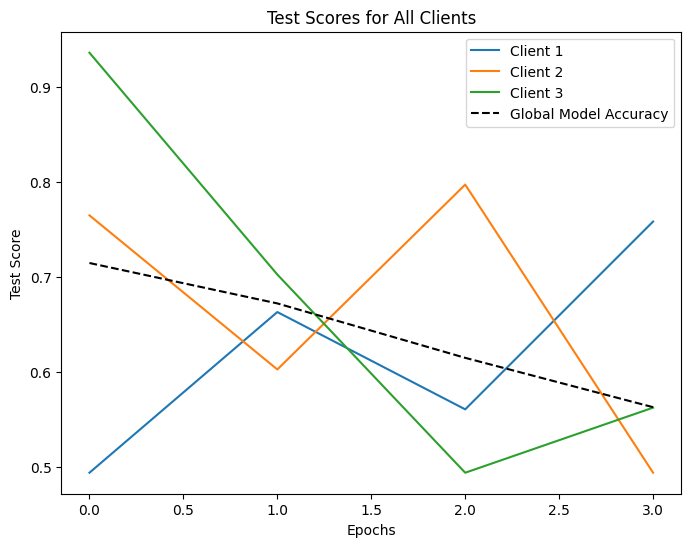

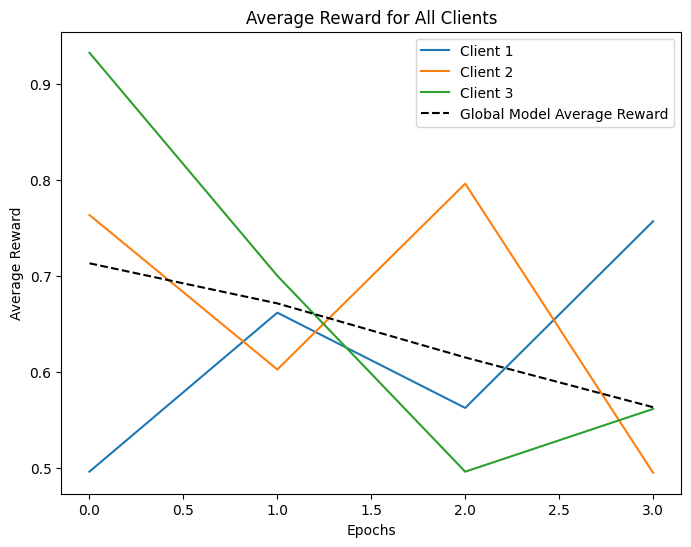

epoch: 4
Index: 0, Client: <__main__.Client object at 0x0000023426A059D0>
Train Sequences Shape: (100, 5)
Train Labels Shape: (100,)
Training Started
action: [1 1 1 1 0 0 1 1 1 0 1 1 1 0 0 0 0 1 1 1 1 0 1 1 1 0 1 0 0 0 0 1 0 0 1 0 1
 1 1 0 0 0 0 1 0 1 0 1 1 0 1 1 1 0 1 1 1 0 0 0 0 0 0 0 1 0 1 0 0 1 1 0 1 0
 0 1 0 1 0 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 0 0 1 1 0 0]
Loss_5: 36.97531849611046
sum_reward: 98.0
reward_avg: 0.98
Score: 0.9749333333333333
action: [1 1 1 1 0 0 1 1 1 0 1 1 1 0 0 0 0 1 1 1 1 0 1 1 1 0 1 0 0 0 0 1 0 0 1 0 1
 1 1 0 0 0 0 1 0 1 0 1 1 0 1 1 1 0 1 1 1 0 0 0 0 0 0 0 1 0 1 0 0 1 1 0 1 0
 0 1 0 1 0 0 1 0 0 0 0 1 1 1 0 1 1 1 1 1 0 0 1 1 0 0]
Loss_5: 43.43322002420935
sum_reward: 99.0
reward_avg: 0.99
Score: 0.9749333333333333
action: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Loss_5: 42.3799643635639
sum_reward: 48.0


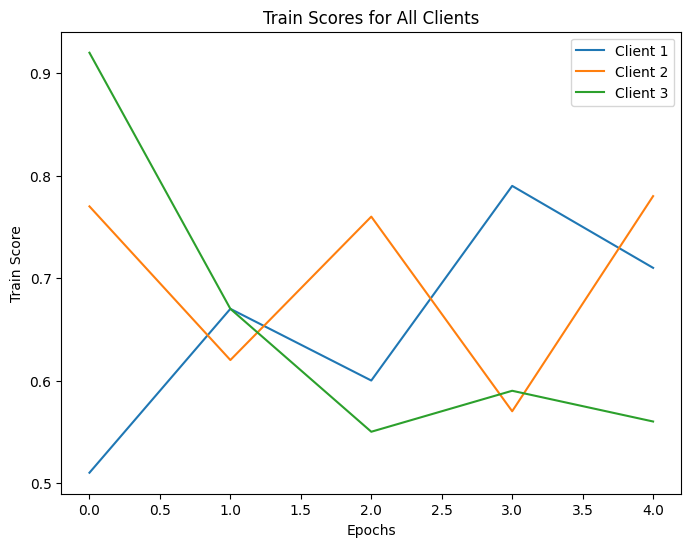

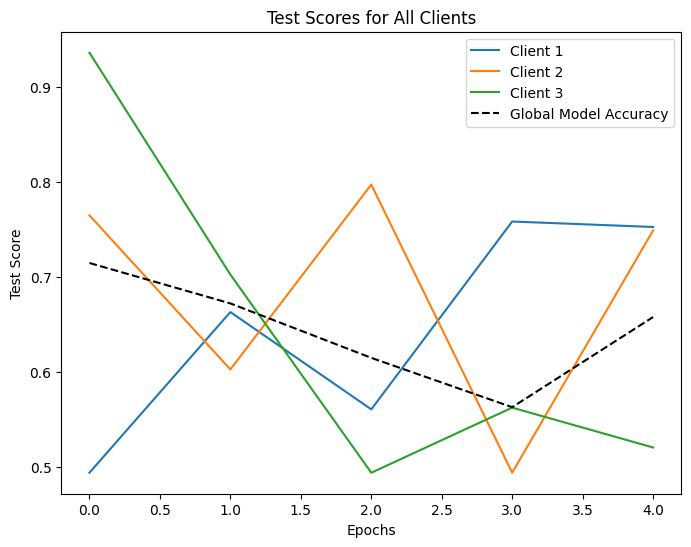

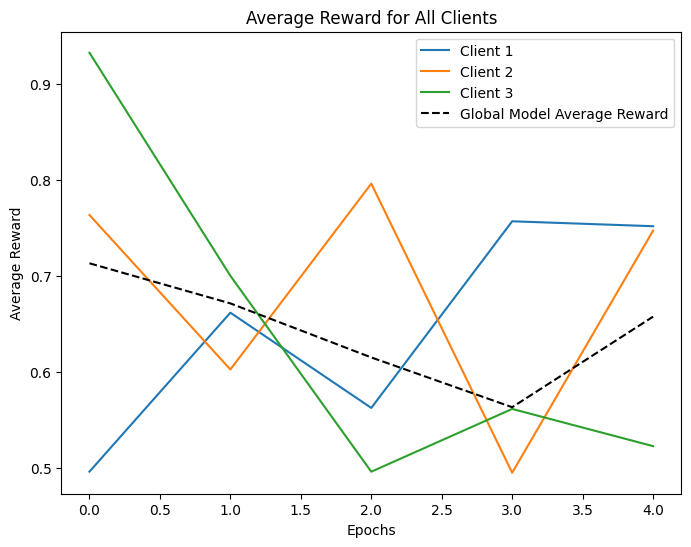

epoch: 5
Index: 0, Client: <__main__.Client object at 0x0000023426A059D0>
Train Sequences Shape: (100, 5)
Train Labels Shape: (100,)
Training Started
action: [1 1 0 1 1 1 0 1 1 1 1 0 1 0 0 1 1 0 0 1 0 0 1 0 1 0 0 1 1 1 0 0 1 0 0 0 0
 0 0 1 1 0 0 0 0 0 0 1 0 0 1 1 1 0 0 0 1 0 0 1 0 1 1 0 1 1 0 1 1 1 1 0 1 0
 0 1 0 1 1 1 0 1 0 1 0 0 0 0 1 1 1 0 0 0 1 1 0 1 0 1]
Loss_5: 36.842496842922756
sum_reward: 95.0
reward_avg: 0.95
Score: 0.9528666666666666
action: [1 1 0 1 1 1 0 1 1 1 1 0 1 0 0 1 1 0 0 1 0 0 1 0 1 0 0 1 1 1 0 0 1 0 0 0 0
 0 0 1 1 0 0 0 0 0 0 1 0 0 1 1 1 0 0 0 1 0 0 1 0 1 1 0 1 1 0 0 1 1 1 0 1 0
 0 1 0 1 1 1 0 1 0 1 0 0 0 0 1 1 1 0 0 0 1 1 0 1 0 1]
Loss_5: 43.46762115012681
sum_reward: 96.0
reward_avg: 0.96
Score: 0.9528666666666666
action: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Loss_5: 41.66481565142814
sum_reward: 48.

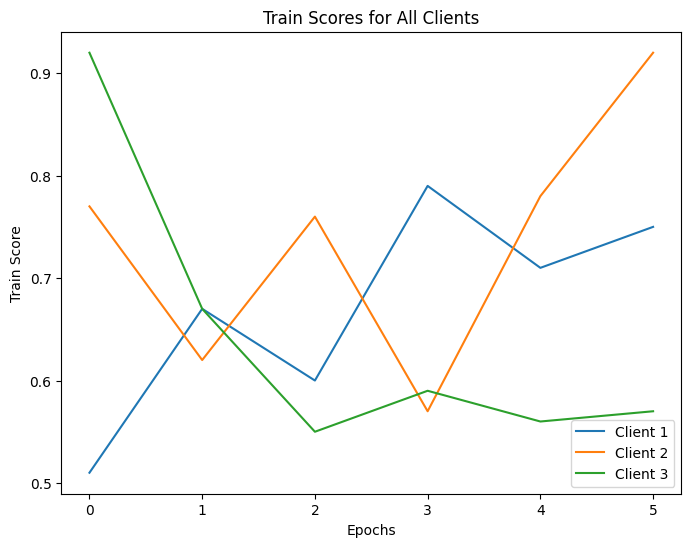

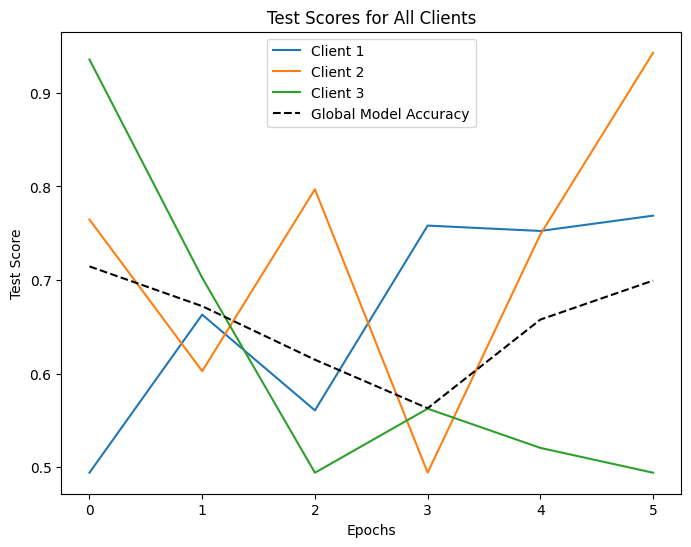

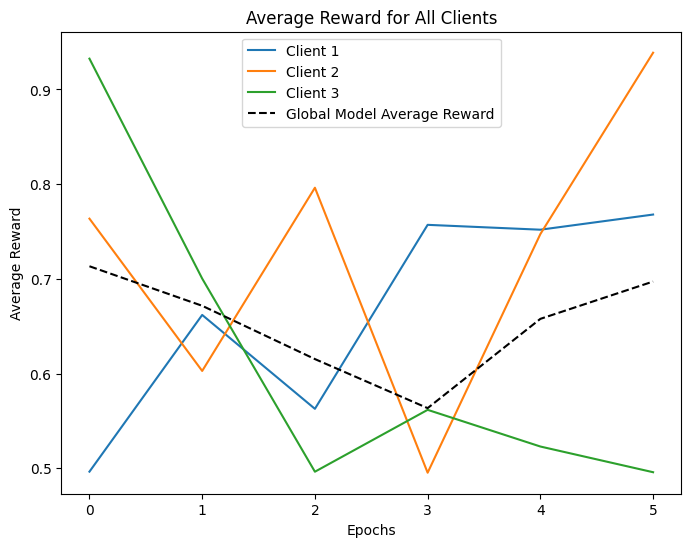

epoch: 6
Index: 0, Client: <__main__.Client object at 0x0000023426A059D0>
Train Sequences Shape: (100, 5)
Train Labels Shape: (100,)
Training Started
action: [1 0 0 1 0 1 1 0 1 0 1 0 0 1 0 1 0 0 0 1 1 0 1 0 1 0 1 0 1 1 1 1 0 1 0 0 1
 1 0 0 0 1 1 1 1 0 0 1 1 0 1 0 1 1 1 0 0 1 1 0 0 0 1 0 0 1 1 0 0 0 1 0 1 0
 1 1 1 1 0 0 0 0 0 1 0 0 1 1 1 0 0 1 1 1 0 0 0 1 0 1]
Loss_5: 37.40917884412931
sum_reward: 99.0
reward_avg: 0.99
Score: 0.9672
action: [1 0 0 1 0 1 1 0 1 0 1 0 0 1 0 1 0 0 0 1 1 0 1 0 1 0 1 0 1 1 1 1 0 1 0 0 1
 1 0 0 0 1 1 1 1 0 0 1 1 0 1 0 1 1 1 0 0 1 1 0 0 1 1 0 0 1 1 0 0 0 1 0 1 0
 1 1 1 1 0 0 0 0 0 1 0 0 1 1 1 0 0 1 1 1 0 0 0 1 0 1]
Loss_5: 42.7423043955429
sum_reward: 98.0
reward_avg: 0.98
Score: 0.9672
action: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Loss_5: 42.65384857135428
sum_reward: 49.0
reward_avg: 0.49
Score: 

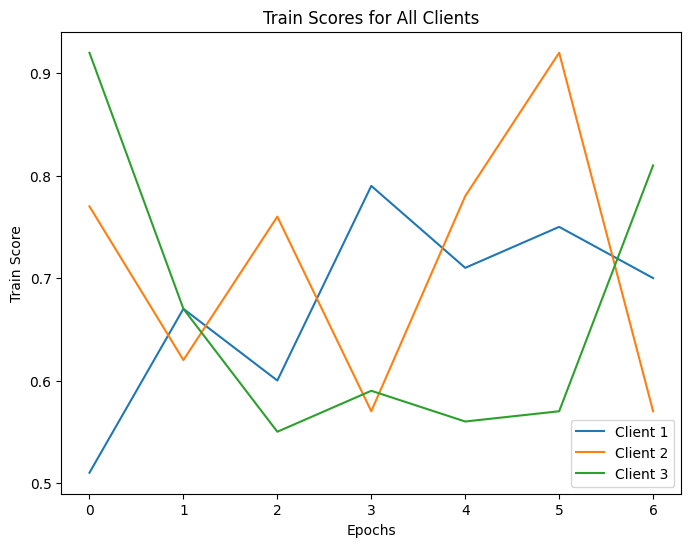

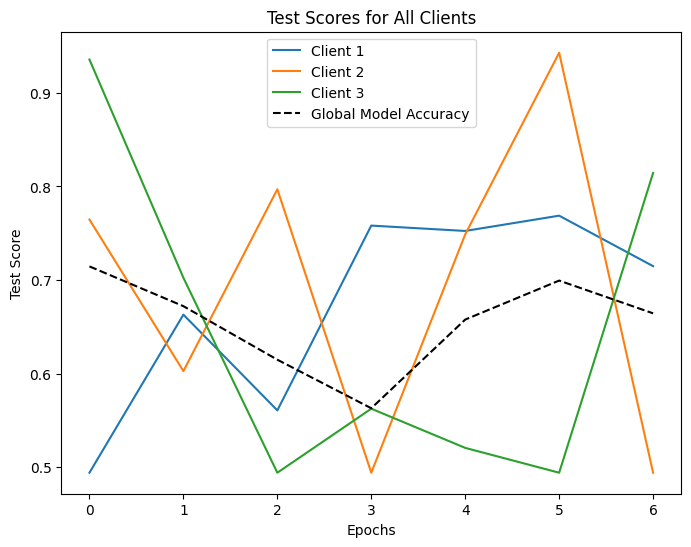

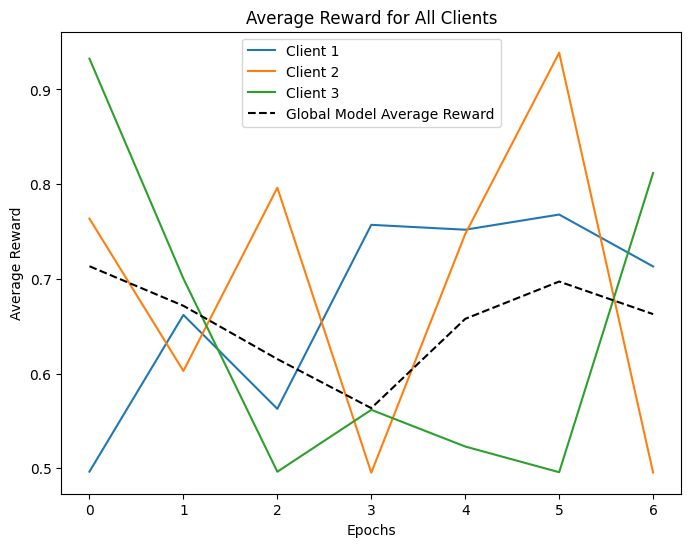

epoch: 7
Index: 0, Client: <__main__.Client object at 0x0000023426A059D0>
Train Sequences Shape: (100, 5)
Train Labels Shape: (100,)
Training Started
action: [1 1 0 0 1 0 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 0 0 1 0 1
 1 1 1 1 0 0 1 1 1 1 1 0 1 0 1 1 1 1 0 1 0 0 1 1 1 1 0 1 1 1 1 0 1 1 1 0 0
 1 0 0 1 1 1 0 0 0 1 0 1 0 1 1 0 0 1 1 0 1 1 1 0 1 1]
Loss_5: 34.954808536480876
sum_reward: 94.0
reward_avg: 0.94
Score: 0.8811333333333333
action: [1 1 0 0 1 0 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 0 0 1 0 1
 1 1 1 1 0 0 1 0 1 1 1 0 1 0 1 1 1 1 0 1 0 0 1 1 1 1 0 1 1 1 1 0 1 1 1 0 0
 1 0 0 1 1 1 0 0 0 1 0 1 0 1 1 0 0 1 1 0 1 1 1 1 1 1]
Loss_5: 42.17761485801304
sum_reward: 94.0
reward_avg: 0.94
Score: 0.8811333333333333
action: [1 1 0 0 0 0 1 1 1 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 1 1 0 1 1 0 0 1 0 1
 1 1 1 1 0 0 1 0 0 1 1 0 1 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 1 1 1 0 1 0 1 0 0
 0 0 0 1 1 0 0 0 0 1 0 1 0 1 1 0 0 1 0 0 1 0 1 0 1 1]
Loss_5: 43.53019303354217
sum_reward: 83.

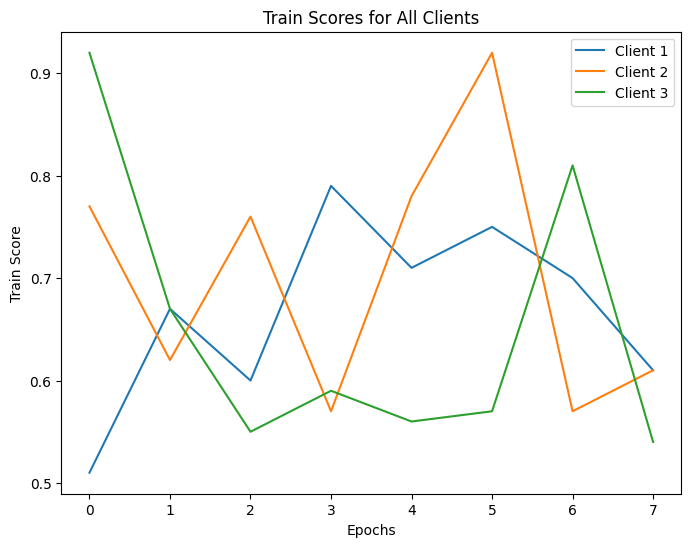

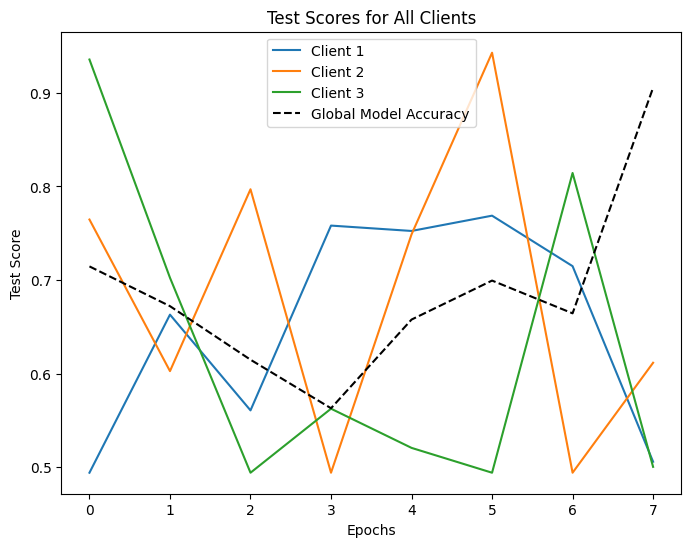

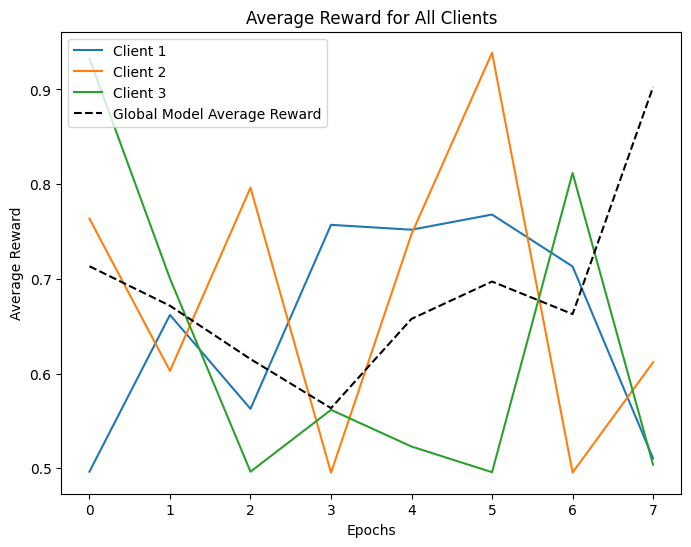

epoch: 8
Index: 0, Client: <__main__.Client object at 0x0000023426A059D0>
Train Sequences Shape: (100, 5)
Train Labels Shape: (100,)
Training Started
action: [0 0 0 1 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 0 1 0 1 1 0 1 0 0 1
 1 0 1 1 0 0 1 1 0 0 0 0 1 1 1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 0 0 0 0 1 0
 0 0 1 1 1 1 0 0 0 1 1 0 0 0 1 1 0 0 1 0 1 0 1 1 1 1]
Loss_5: 36.69785590932217
sum_reward: 98.0
reward_avg: 0.98
Score: 0.9964
action: [0 0 0 1 1 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 0 1 0 1 1 0 1 0 0 1
 0 0 1 1 0 0 1 1 0 0 0 0 1 1 1 1 0 0 0 1 1 1 1 0 1 1 1 1 1 0 1 0 0 0 0 1 0
 0 0 1 1 1 1 0 0 0 1 1 0 0 0 1 1 0 0 1 0 1 0 1 0 1 1]
Loss_5: 42.596404470045854
sum_reward: 94.0
reward_avg: 0.94
Score: 0.9964
action: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Loss_5: 42.48534467195786
sum_reward: 49.0
reward_avg: 0.49
Score

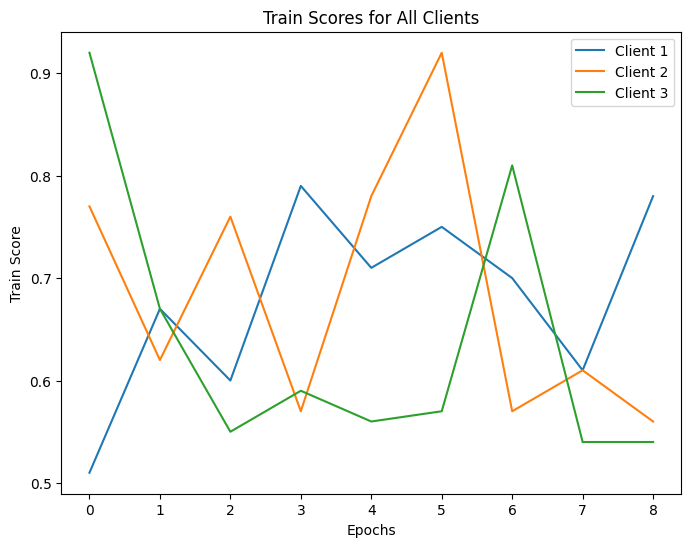

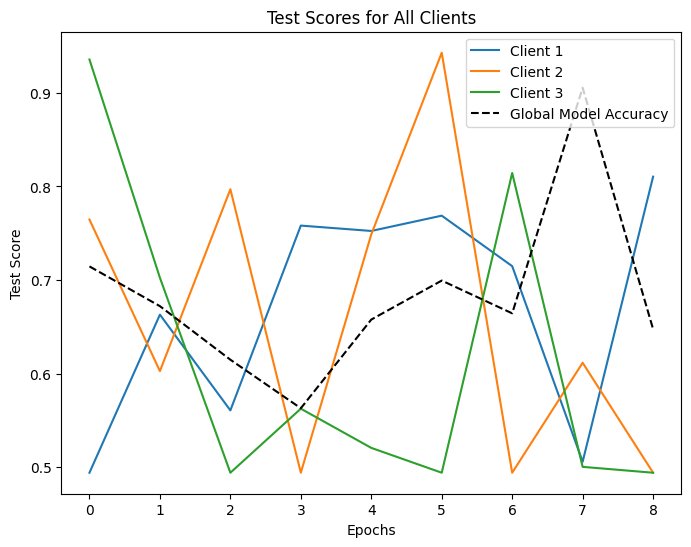

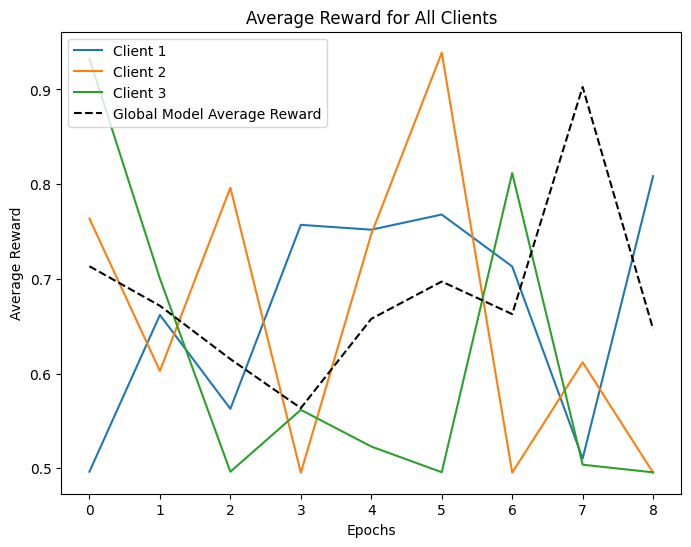

epoch: 9
Index: 0, Client: <__main__.Client object at 0x0000023426A059D0>
Train Sequences Shape: (100, 5)
Train Labels Shape: (100,)
Training Started
action: [1 0 0 1 0 0 1 0 1 1 0 1 1 1 1 1 1 0 1 1 1 0 0 1 0 0 0 1 1 0 1 1 0 1 0 1 0
 0 1 1 0 1 0 0 1 1 0 1 0 0 1 0 1 1 0 0 1 0 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1
 1 0 1 1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 0 1 0 0 0 1 1 0]
Loss_5: 36.87757288688341
sum_reward: 92.0
reward_avg: 0.92
Score: 0.9287333333333333
action: [1 0 0 1 0 0 1 0 1 1 0 1 1 1 1 1 1 0 1 1 1 0 0 1 0 0 0 1 1 0 1 1 0 1 0 1 0
 1 1 1 0 1 0 0 1 1 0 1 0 0 1 0 1 1 0 0 1 0 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1
 1 0 1 1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 0 1 0 0 0 1 1 0]
Loss_5: 42.8997297071806
sum_reward: 93.0
reward_avg: 0.93
Score: 0.9287333333333333
action: [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 1 0 1 0
 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0]
Loss_5: 43.911371300938946
sum_reward: 67.0

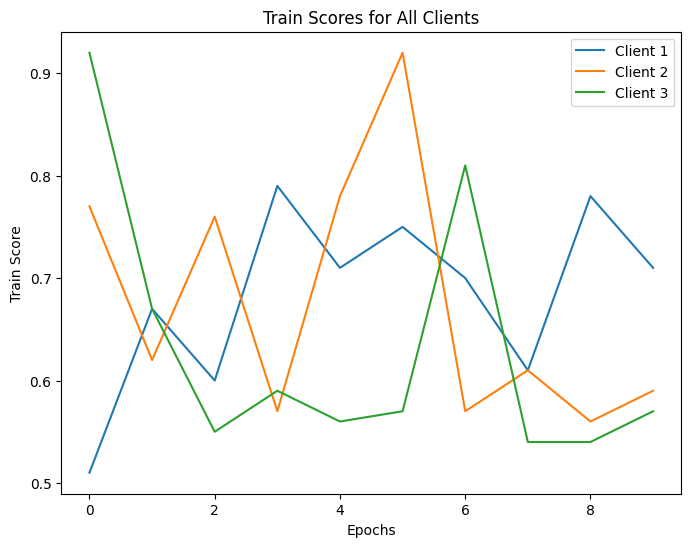

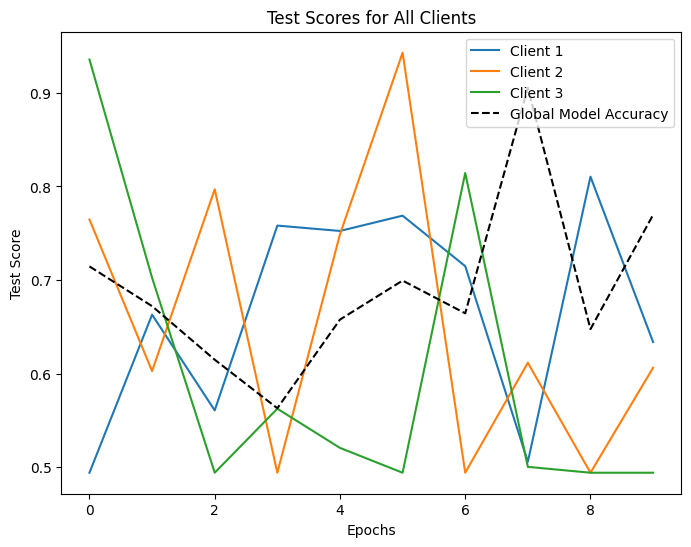

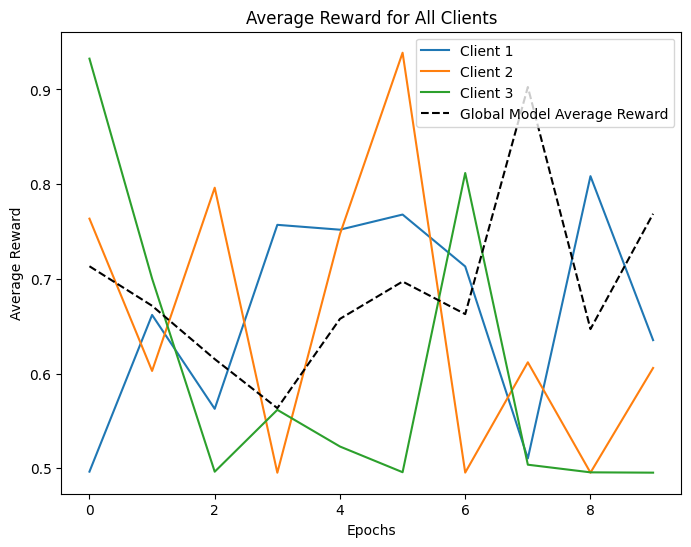

epoch: 10
Index: 0, Client: <__main__.Client object at 0x0000023426A059D0>
Train Sequences Shape: (100, 5)
Train Labels Shape: (100,)
Training Started
action: [0 0 1 0 0 1 0 1 1 1 0 1 0 0 1 1 0 0 0 1 0 1 1 0 0 1 1 1 0 0 1 0 1 1 0 1 0
 1 0 1 0 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 1 0
 0 0 1 1 1 0 0 1 1 1 0 1 1 1 0 1 1 1 0 1 0 0 0 0 0 1]
Loss_5: 36.04330654564944
sum_reward: 95.0
reward_avg: 0.95
Score: 0.9482
action: [0 0 1 0 0 1 0 1 1 1 0 1 0 0 1 1 0 0 0 1 1 1 1 0 0 1 1 1 0 0 1 0 1 1 0 1 0
 1 0 1 0 0 0 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 1 0
 0 0 1 1 1 0 0 1 1 1 0 1 1 1 0 1 1 1 0 1 0 0 0 0 0 1]
Loss_5: 42.8490587999742
sum_reward: 97.0
reward_avg: 0.97
Score: 0.9482
action: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Loss_5: 41.171210409624635
sum_reward: 52.0
reward_avg: 0.52
Score

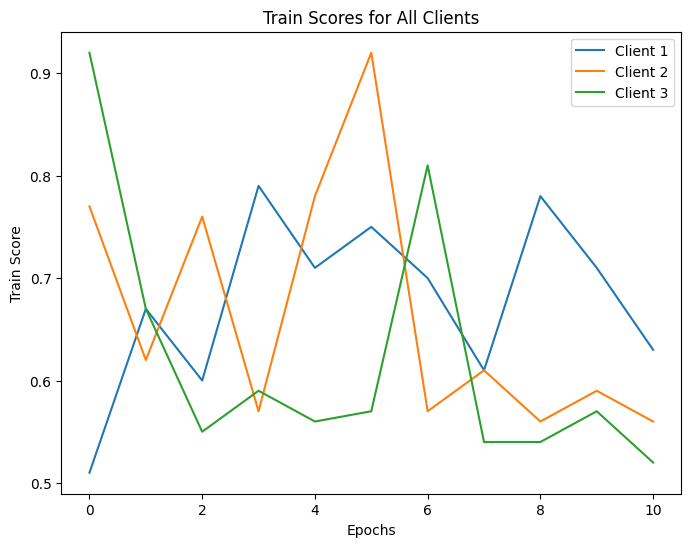

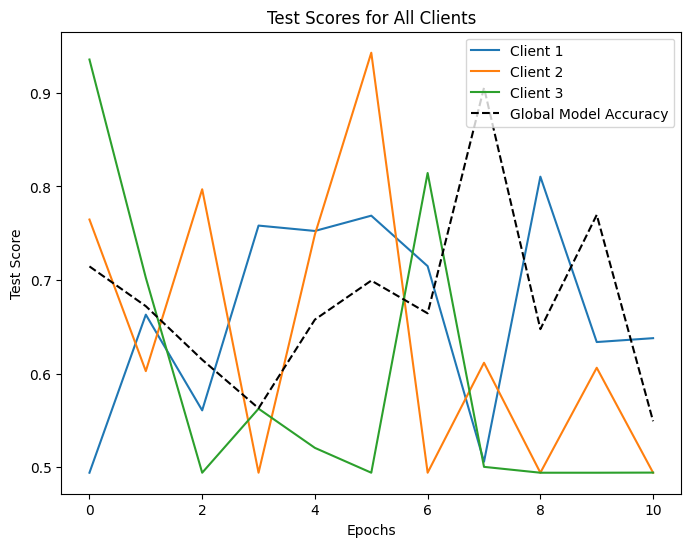

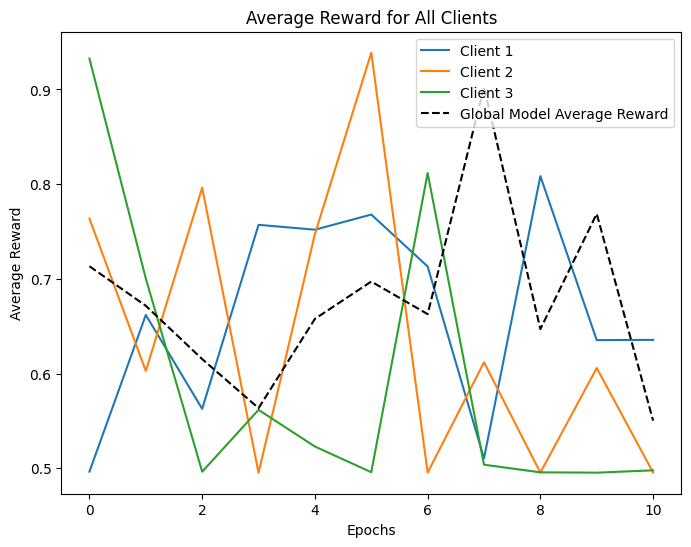

epoch: 11
Index: 0, Client: <__main__.Client object at 0x0000023426A059D0>
Train Sequences Shape: (100, 5)
Train Labels Shape: (100,)
Training Started
action: [1 0 1 0 1 1 0 1 0 1 1 1 0 0 0 1 0 0 1 0 1 1 0 0 0 0 1 0 0 1 1 0 1 0 0 0 1
 0 0 1 1 0 1 0 0 1 0 1 1 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 1 0
 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 0 0 1 0 1 0 1 0 1 1 0]
Loss_5: 38.375915277766275
sum_reward: 94.0
reward_avg: 0.94
Score: 0.9486666666666667
action: [1 0 1 1 1 1 0 1 0 1 1 1 0 0 0 1 0 0 1 0 1 1 0 0 0 0 1 0 0 1 1 0 1 0 0 0 1
 0 0 1 1 0 1 0 0 1 0 1 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 1 0
 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 1 0 0]
Loss_5: 44.00591377615321
sum_reward: 90.0
reward_avg: 0.9
Score: 0.9486666666666667
action: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
Loss_5: 42.79942352190863
sum_reward: 52.

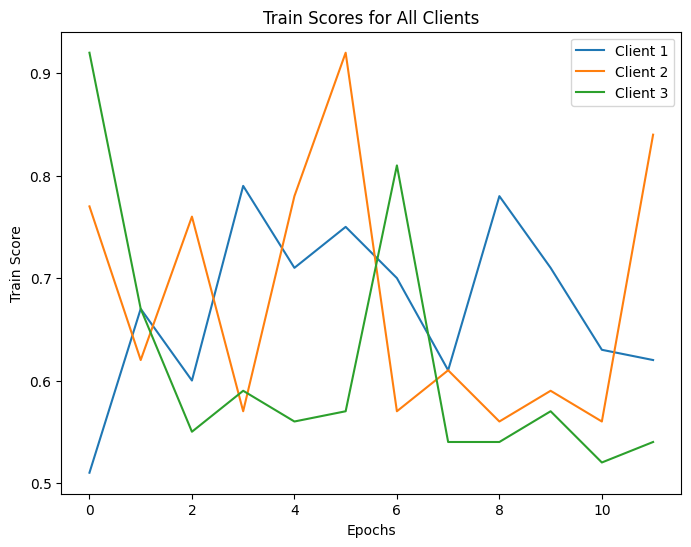

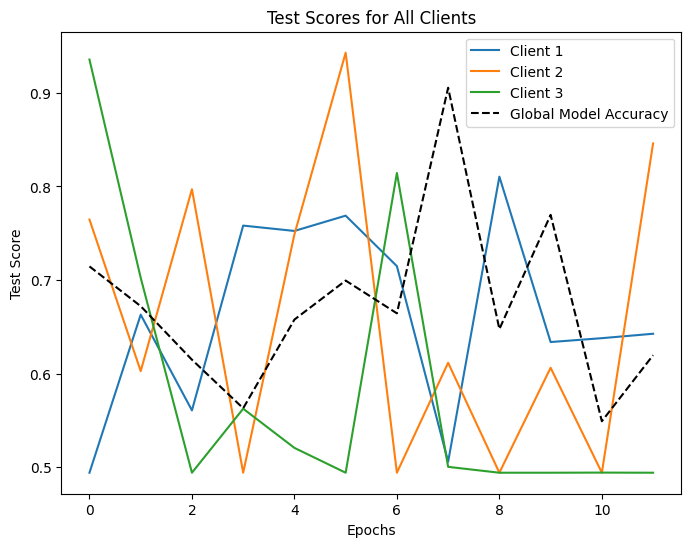

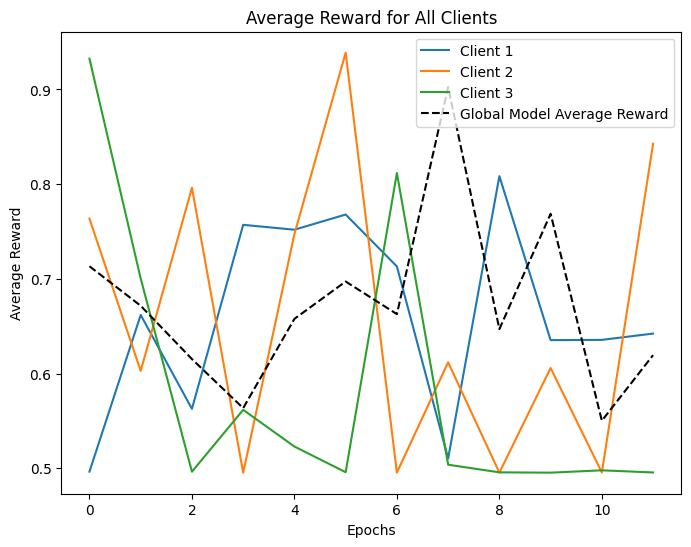

epoch: 12
Index: 0, Client: <__main__.Client object at 0x0000023426A059D0>
Train Sequences Shape: (100, 5)
Train Labels Shape: (100,)
Training Started
action: [1 0 1 1 0 1 0 0 0 1 1 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0 1 1 1 1 1 1 0 1 0 1 1
 0 1 1 1 1 0 1 1 0 1 0 1 0 1 0 1 0 0 0 1 1 0 0 1 1 1 1 1 0 0 0 1 0 1 0 1 0
 0 1 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 1 0 1 0 0]
Loss_5: 37.730254371765106
sum_reward: 96.0
reward_avg: 0.96
Score: 0.9784
action: [1 0 1 1 0 1 0 0 0 1 1 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0 1 1 1 1 1 1 0 1 0 1 1
 0 1 1 1 1 0 1 1 0 1 0 1 0 1 0 1 0 0 0 1 1 0 0 1 1 1 1 1 0 0 0 1 0 1 0 1 0
 0 1 1 0 0 0 0 0 0 1 0 0 1 1 0 0 0 1 0 0 0 1 0 1 0 0]
Loss_5: 42.31465317808927
sum_reward: 97.0
reward_avg: 0.97
Score: 0.9784
action: [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
Loss_5: 41.0096081002234
sum_reward: 57.0
reward_avg: 0.57
Score

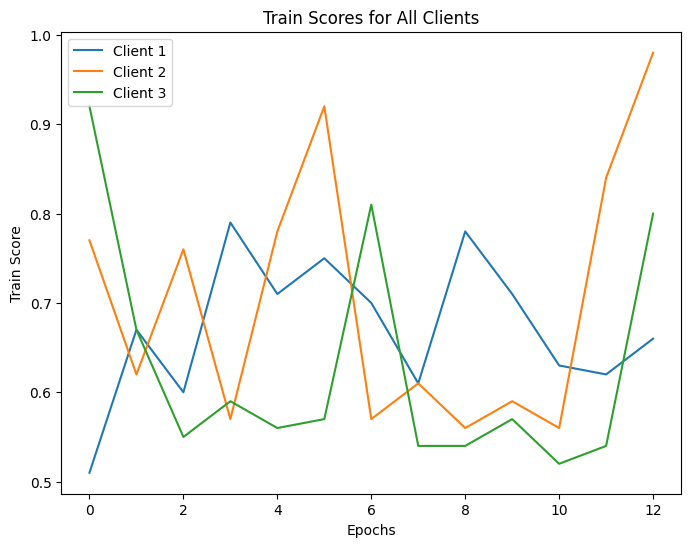

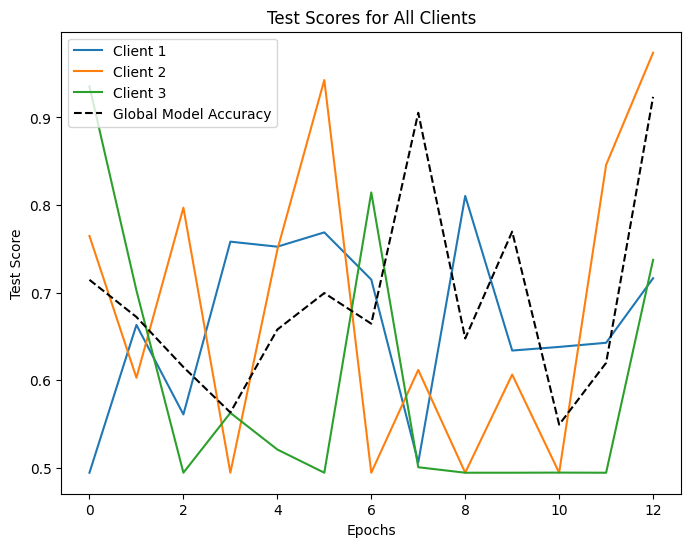

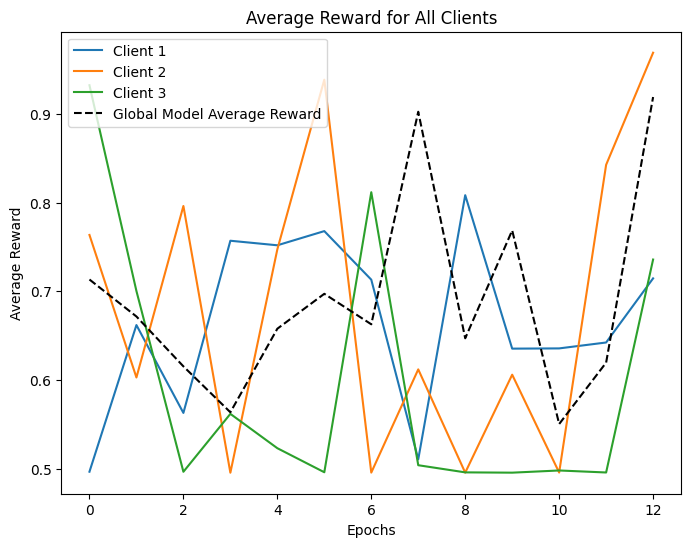

epoch: 13
Index: 0, Client: <__main__.Client object at 0x0000023426A059D0>
Train Sequences Shape: (100, 5)
Train Labels Shape: (100,)
Training Started
action: [0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 1 0 0 0 0 0 1 1 1 0 0
 0 0 0 1 0 1 0 1 1 0 0 1 0 0 1 0 1 0 0 1 1 1 1 1 0 1 1 0 0 0 0 1 0 1 0 0 0
 0 1 0 1 0 1 1 0 0 0 0 1 0 1 0 1 0 0 1 0 0 0 1 0 1 0]
Loss_5: 36.71269793550872
sum_reward: 91.0
reward_avg: 0.91
Score: 0.9042
action: [0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 1 0 0 0 1 0 1 1 1 0 0
 0 0 0 1 0 1 0 1 1 0 0 1 0 0 1 0 1 0 0 1 1 1 1 1 0 1 1 0 0 0 0 1 0 1 0 0 0
 0 1 0 1 0 1 1 0 0 0 0 1 0 1 0 1 0 0 1 0 0 0 1 0 1 0]
Loss_5: 43.03334047150807
sum_reward: 90.0
reward_avg: 0.9
Score: 0.9042
action: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Loss_5: 40.93845166531125
sum_reward: 55.0
reward_avg: 0.55
Score:

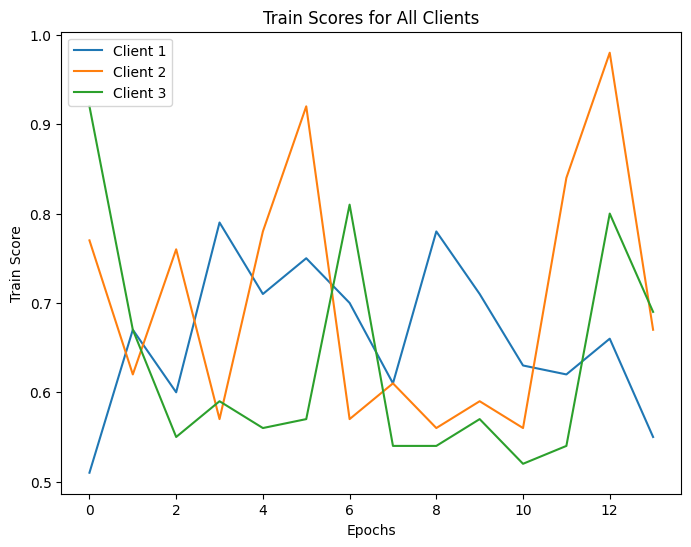

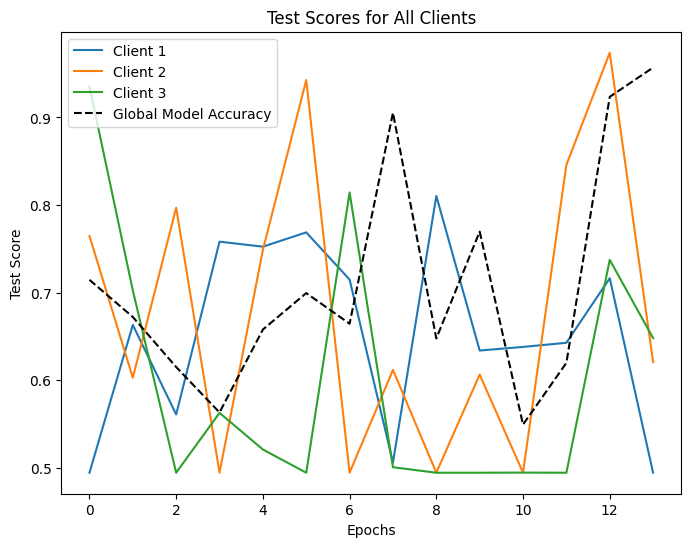

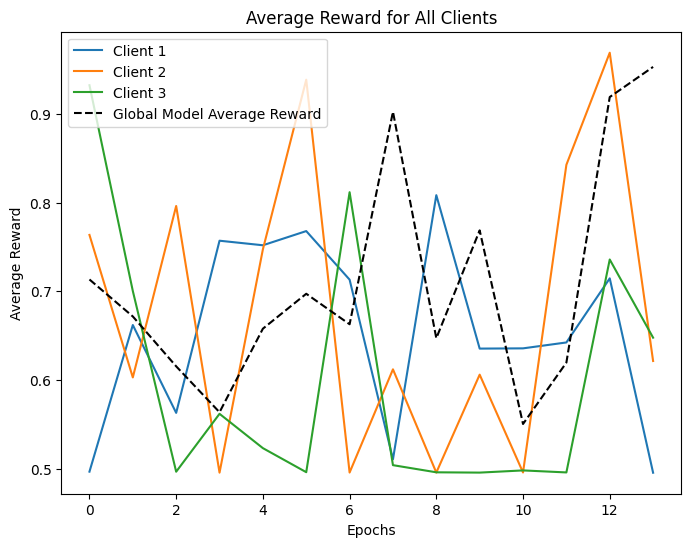

epoch: 14
Index: 0, Client: <__main__.Client object at 0x0000023426A059D0>
Train Sequences Shape: (100, 5)
Train Labels Shape: (100,)
Training Started
action: [1 1 1 0 0 1 1 1 0 0 0 0 1 0 1 1 0 1 1 1 0 1 1 1 1 0 1 1 1 1 1 0 1 0 0 0 1
 0 1 1 1 1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 0 1 0 0 1 1 0 0 0 0 0
 0 0 0 1 1 0 0 1 0 1 1 0 1 0 0 0 1 0 0 0 0 1 1 0 1 1]
Loss_5: 38.36439589405878
sum_reward: 98.0
reward_avg: 0.98
Score: 0.9991333333333333
action: [1 1 0 0 0 1 1 1 0 0 0 0 1 0 1 1 0 1 1 1 0 0 1 1 1 0 1 1 1 1 1 0 1 0 0 0 0
 0 1 1 1 1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 1 0 0 1 0 0 1 0 1 0 0 1 1 0 0 0 0 0
 0 0 0 1 1 0 0 1 0 1 1 0 1 0 0 0 1 0 0 0 0 1 1 1 1 1]
Loss_5: 43.56992589025697
sum_reward: 97.0
reward_avg: 0.97
Score: 0.9991333333333333
action: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
Loss_5: 43.63056665463842
sum_reward: 50.

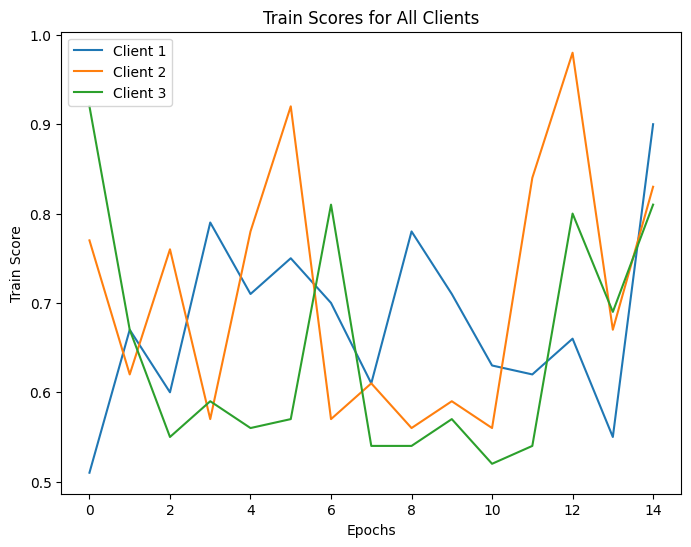

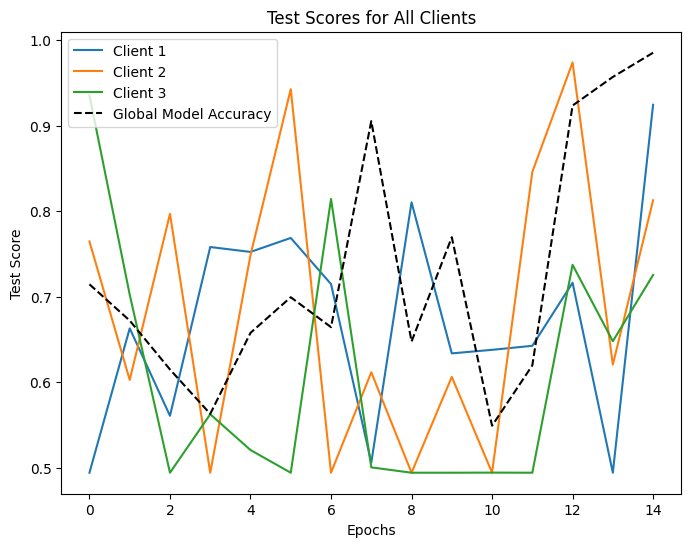

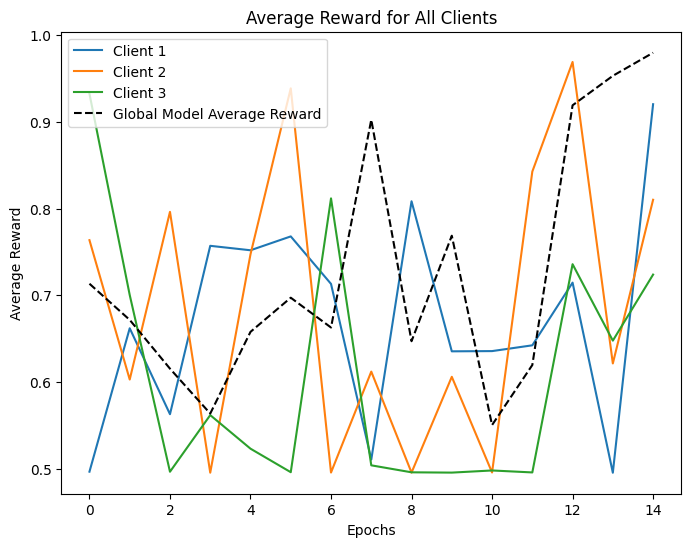

epoch: 15
Index: 0, Client: <__main__.Client object at 0x0000023426A059D0>
Train Sequences Shape: (100, 5)
Train Labels Shape: (100,)
Training Started
action: [0 1 0 0 1 0 1 1 0 0 1 1 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0 1
 0 1 0 0 1 1 1 0 0 0 0 1 0 0 1 0 0 1 0 1 1 0 0 1 0 0 0 0 0 1 0 1 1 1 1 0 0
 0 1 1 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
Loss_5: 36.699508398380324
sum_reward: 88.0
reward_avg: 0.88
Score: 0.9173333333333333
action: [0 1 1 0 1 0 1 1 0 0 1 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0 1
 0 1 0 0 1 1 1 0 0 0 0 1 0 0 1 0 0 1 0 1 1 0 0 1 0 0 0 0 0 1 0 1 1 1 1 0 0
 1 1 1 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
Loss_5: 42.784532211421066
sum_reward: 89.0
reward_avg: 0.89
Score: 0.9173333333333333
action: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Loss_5: 40.820070924098246
sum_reward: 

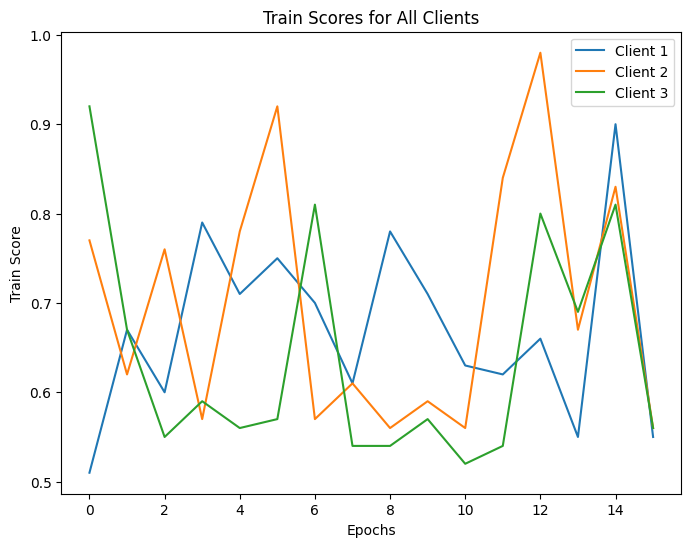

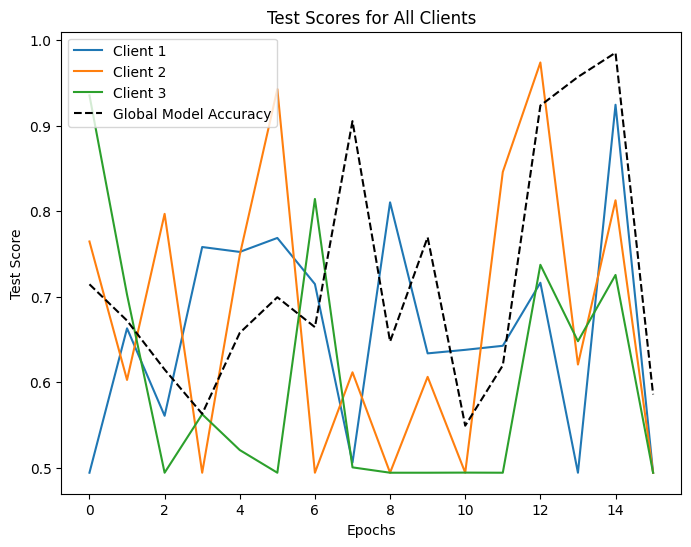

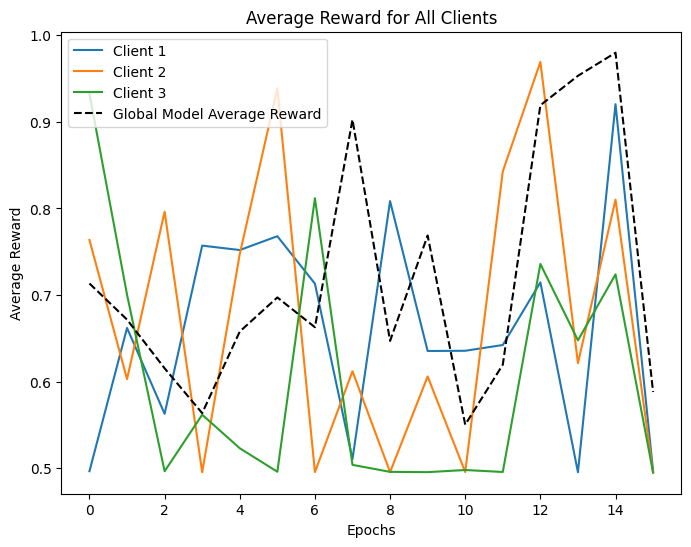

epoch: 16
Index: 0, Client: <__main__.Client object at 0x0000023426A059D0>
Train Sequences Shape: (100, 5)
Train Labels Shape: (100,)
Training Started
action: [1 1 0 0 1 1 0 1 1 0 1 0 0 1 1 1 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 1 1 1 1 0 0
 1 1 1 0 0 1 0 1 0 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 0 1 0 1 1 1 0 1 0 1 1
 1 1 1 1 1 0 0 0 1 0 0 1 0 0 0 1 0 1 1 0 1 1 1 1 0 1]
Loss_5: 37.73031141957522
sum_reward: 95.0
reward_avg: 0.95
Score: 0.9614666666666667
action: [1 1 0 0 1 1 0 1 1 0 1 0 0 1 1 1 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 1 0 1 1 0 0
 1 1 1 0 0 1 0 1 0 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 0 1 0 1 1 1 0 1 0 1 1
 1 1 1 1 1 0 0 0 1 0 0 1 0 0 0 1 0 1 1 0 1 1 1 1 0 1]
Loss_5: 43.37635438328066
sum_reward: 94.0
reward_avg: 0.94
Score: 0.9614666666666667
action: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
Loss_5: 43.526513245332744
sum_reward: 48

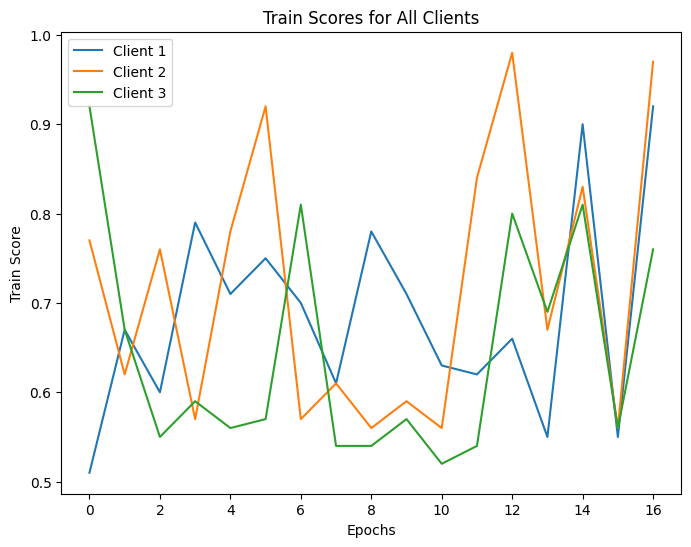

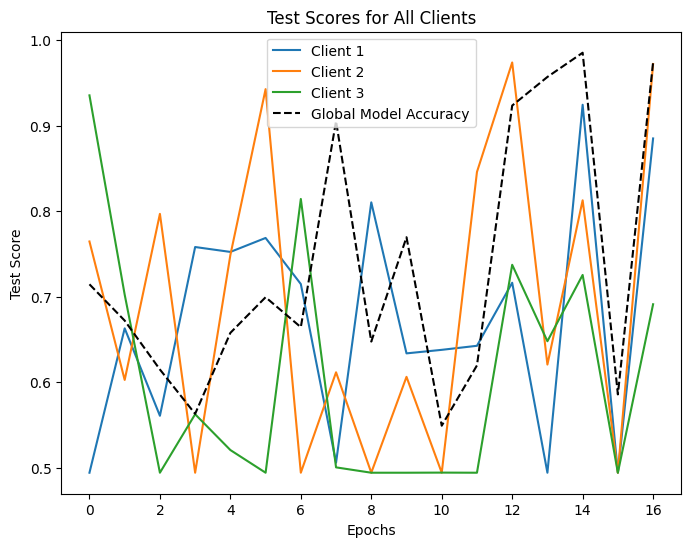

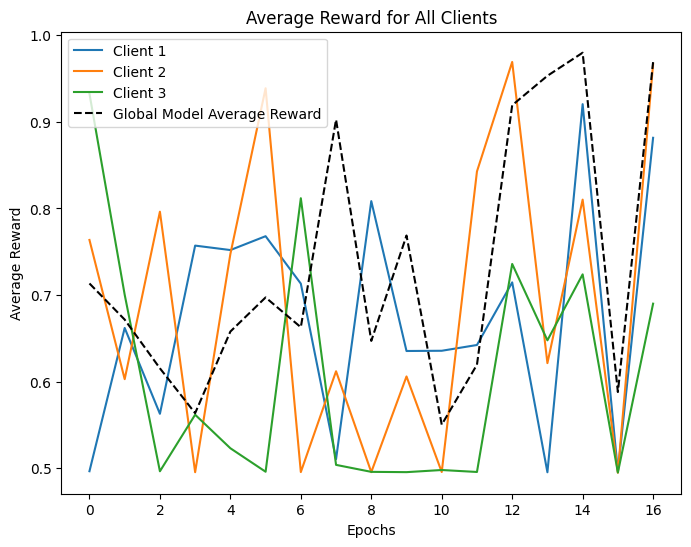

epoch: 17
Index: 0, Client: <__main__.Client object at 0x0000023426A059D0>
Train Sequences Shape: (100, 5)
Train Labels Shape: (100,)
Training Started
action: [1 1 1 0 1 1 1 1 1 0 1 0 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0 1 1 0 0
 1 0 1 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 1 1 1 1 0 1 1 1 1 0 1 1 0 1 1 0 1 1 1
 1 1 1 1 1 1 0 1 0 1 1 0 0 1 1 1 1 1 1 0 1 0 0 0 0 1]
Loss_5: 37.20405309396595
sum_reward: 95.0
reward_avg: 0.95
Score: 0.9199333333333334
action: [1 1 1 0 1 1 1 1 1 0 1 0 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0 1 1 0 0
 1 0 1 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 1 1 1 1 0 1 1 1 1 0 1 1 0 1 1 0 1 1 1
 1 1 1 1 1 1 0 1 0 1 1 0 0 1 1 1 1 1 1 0 1 0 0 0 0 1]
Loss_5: 42.456388456240475
sum_reward: 95.0
reward_avg: 0.95
Score: 0.9199333333333334
action: [1 1 1 0 1 0 1 0 1 0 0 0 0 0 0 1 0 1 1 0 0 1 1 1 0 1 0 0 0 0 0 0 0 1 1 0 0
 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 1 0 1 1 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0
 0 1 1 0 0 0 0 1 0 1 1 0 0 1 1 1 0 1 0 0 0 0 0 0 0 1]
Loss_5: 44.147216873509265
sum_reward: 7

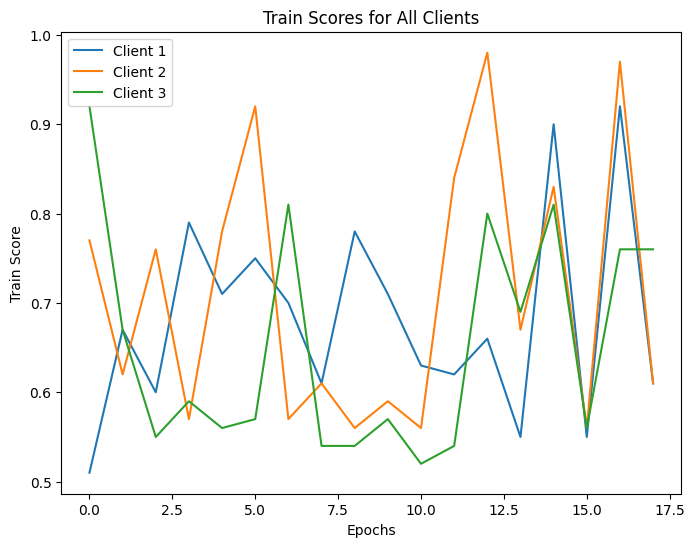

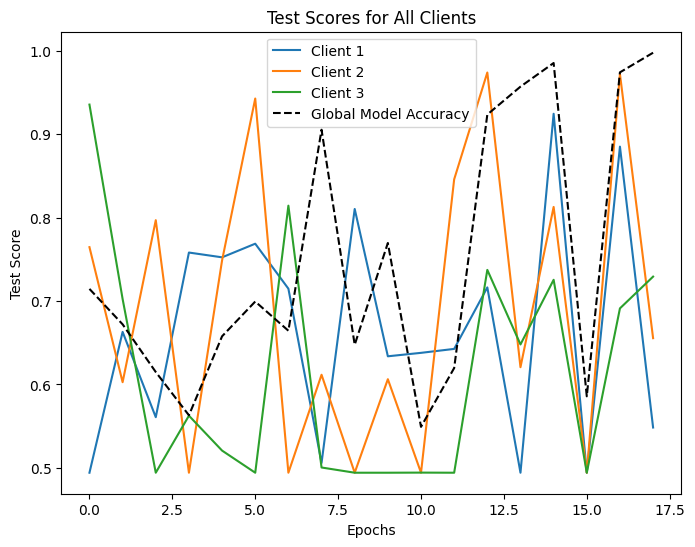

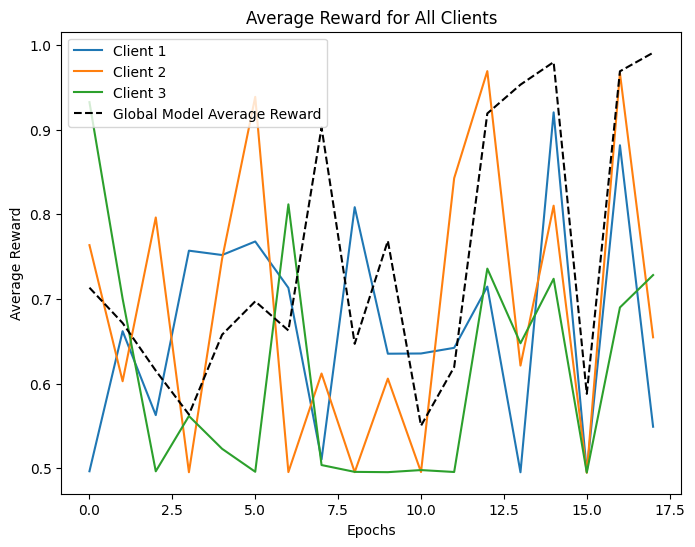

epoch: 18
Index: 0, Client: <__main__.Client object at 0x0000023426A059D0>
Train Sequences Shape: (100, 5)
Train Labels Shape: (100,)
Training Started
action: [0 0 0 0 0 1 0 0 0 0 1 0 1 1 0 0 1 1 0 1 1 0 1 0 0 0 0 1 0 0 1 0 0 1 1 1 0
 1 0 0 1 1 0 1 1 0 0 0 1 1 0 0 0 0 0 0 0 1 0 1 0 1 1 0 1 0 0 0 0 1 0 0 0 0
 1 0 1 0 1 1 1 0 1 1 0 1 0 1 0 0 1 1 1 1 0 0 0 1 1 1]
Loss_5: 36.70542664893493
sum_reward: 94.0
reward_avg: 0.94
Score: 0.9498
action: [0 0 0 0 0 1 0 0 0 0 1 0 1 1 0 0 1 1 0 1 1 0 1 0 0 0 0 1 0 0 1 0 0 1 1 1 0
 1 0 0 1 1 0 1 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1 0 1 1 0 1 0 0 0 0 1 0 0 0 0
 1 0 1 0 1 1 1 0 1 1 0 1 0 0 0 1 1 1 1 1 0 0 0 1 1 1]
Loss_5: 43.01452885084199
sum_reward: 94.0
reward_avg: 0.94
Score: 0.9498
action: [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Loss_5: 41.68683400426333
sum_reward: 49.0
reward_avg: 0.49
Score

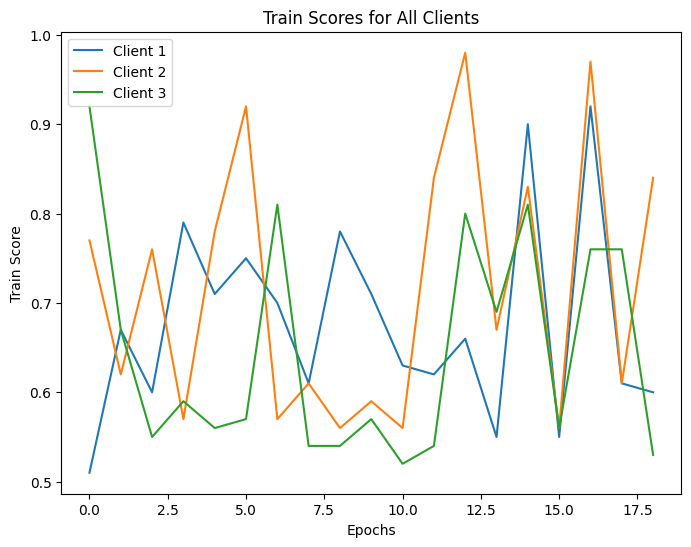

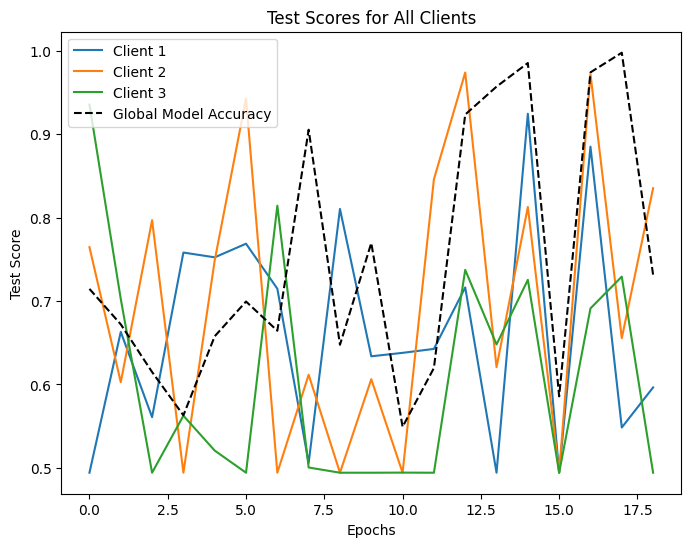

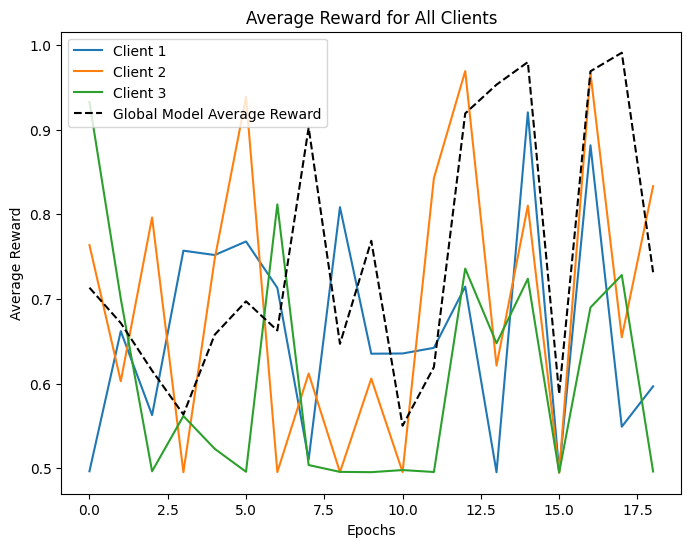

epoch: 19
Index: 0, Client: <__main__.Client object at 0x0000023426A059D0>
Train Sequences Shape: (100, 5)
Train Labels Shape: (100,)
Training Started
action: [1 1 0 0 0 1 1 0 0 1 1 0 1 0 1 0 0 1 0 0 1 0 1 1 0 0 0 1 1 1 1 1 0 0 1 0 0
 1 0 1 1 1 0 1 1 1 1 1 1 1 0 0 1 1 0 0 1 0 0 1 1 1 1 0 1 1 0 0 1 0 0 1 0 1
 1 1 1 0 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 1 0 0 1]
Loss_5: 38.00079580585018
sum_reward: 96.0
reward_avg: 0.96
Score: 0.9744
action: [1 1 0 0 0 1 1 0 0 1 1 0 1 0 1 0 0 1 0 0 1 0 1 1 0 0 0 1 1 1 1 1 0 0 1 0 0
 1 0 1 1 1 0 1 1 1 1 1 1 1 0 0 1 1 0 0 1 0 0 1 1 1 1 0 1 1 0 0 1 0 0 1 0 1
 1 1 1 0 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 1 0 0 1]
Loss_5: 43.5371929152502
sum_reward: 96.0
reward_avg: 0.96
Score: 0.9744
action: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Loss_5: 44.60861634265693
sum_reward: 45.0
reward_avg: 0.45
Score:

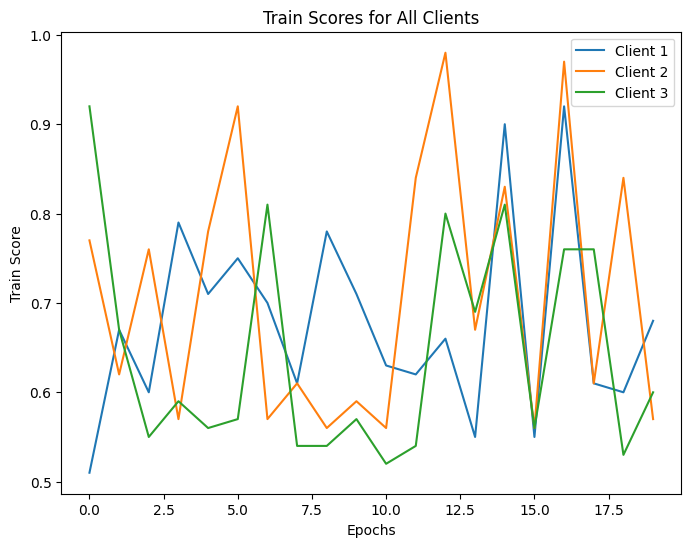

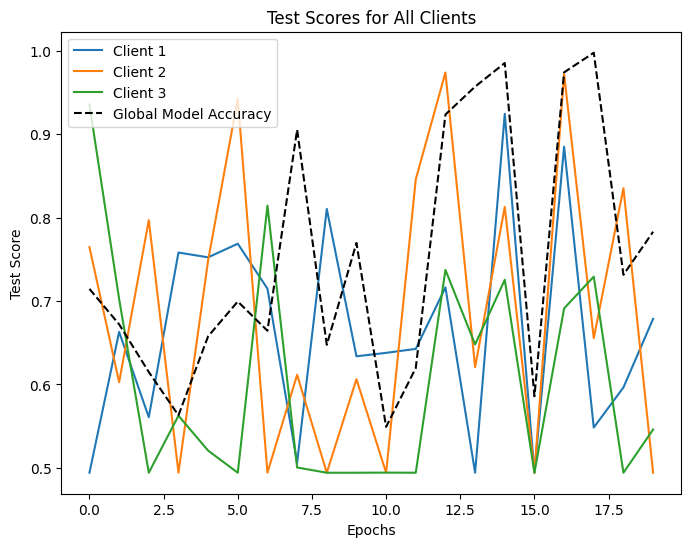

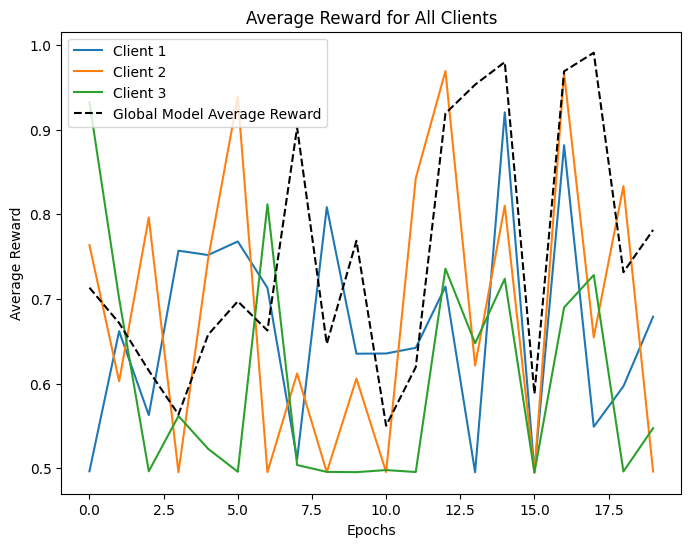

epoch: 20
Index: 0, Client: <__main__.Client object at 0x0000023426A059D0>
Train Sequences Shape: (100, 5)
Train Labels Shape: (100,)
Training Started
action: [1 0 1 0 0 0 0 1 1 0 1 0 0 1 1 0 0 1 0 0 1 0 1 1 1 1 0 1 1 0 0 1 1 0 1 1 1
 1 1 1 1 1 0 1 1 1 0 1 1 0 1 0 0 1 0 0 0 0 1 0 0 1 0 1 1 0 1 0 0 0 0 1 0 1
 0 1 1 0 1 0 1 0 1 0 1 1 1 0 0 0 1 0 1 1 0 0 1 0 0 0]
Loss_5: 36.87647052735251
sum_reward: 99.0
reward_avg: 0.99
Score: 0.9796
action: [1 0 1 0 0 0 0 1 1 0 1 0 0 1 1 0 0 1 0 0 1 0 1 1 1 1 0 1 1 0 0 1 1 0 1 1 1
 1 1 1 1 1 0 1 1 1 0 1 1 0 1 0 0 1 0 0 0 0 1 0 0 1 0 1 1 0 1 0 0 0 0 1 1 1
 0 1 1 0 1 0 1 0 1 0 1 1 1 0 0 0 1 0 1 1 0 0 1 0 0 0]
Loss_5: 42.587483219575695
sum_reward: 98.0
reward_avg: 0.98
Score: 0.9796
action: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Loss_5: 41.802824436007796
sum_reward: 48.0
reward_avg: 0.48
Sco

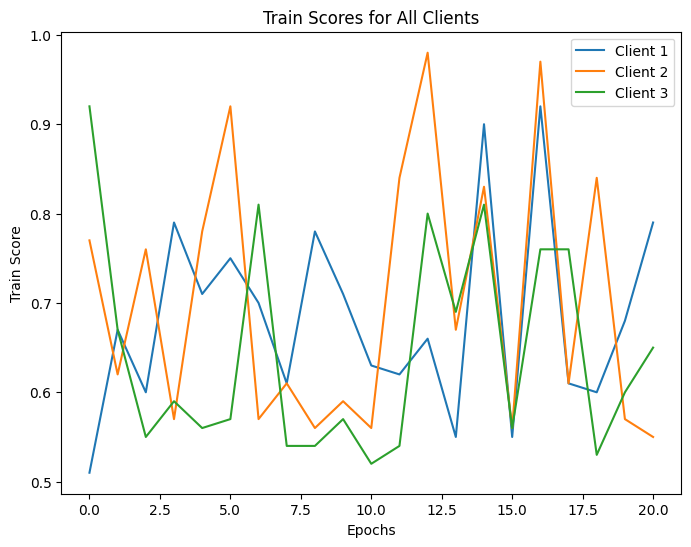

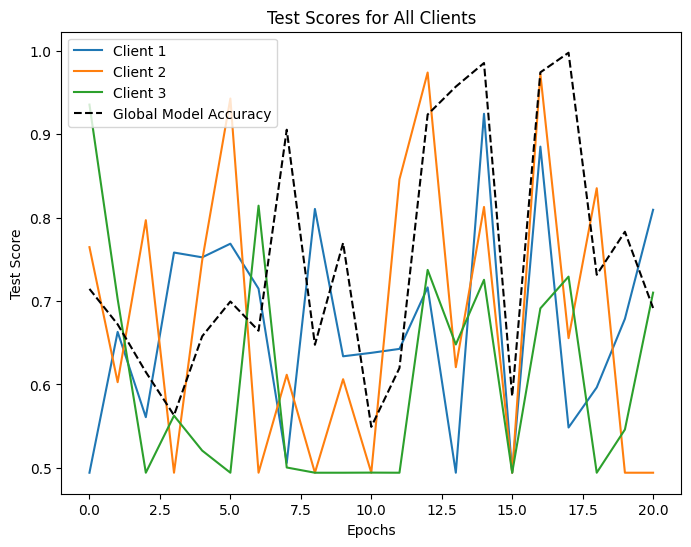

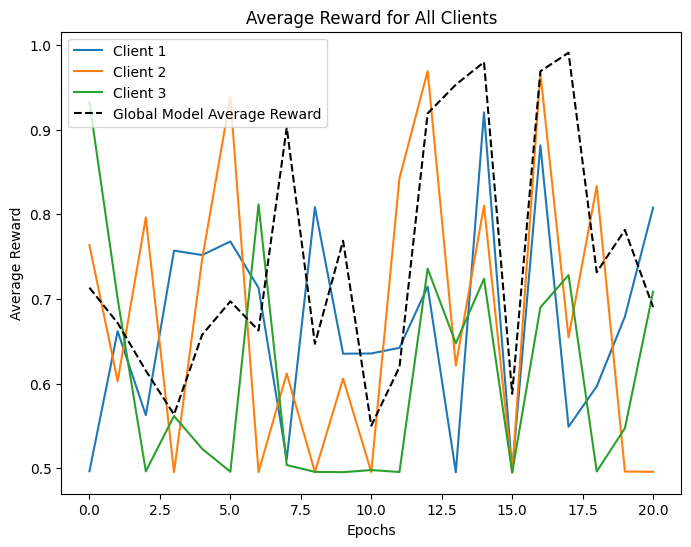

epoch: 21
Index: 0, Client: <__main__.Client object at 0x0000023426A059D0>
Train Sequences Shape: (100, 5)
Train Labels Shape: (100,)
Training Started
action: [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 1 0 0 0 1 0 1 1
 1 1 1 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0
 1 0 0 0 1 1 0 0 0 0 1 0 0 1 0 0 1 0 1 1 0 0 0 1 1 1]
Loss_5: 37.12409767507566
sum_reward: 86.0
reward_avg: 0.86
Score: 0.9128666666666667
action: [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 1 0 0 0 1 0 1 1
 1 1 1 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 1 0 0 1 0 0 0 0
 0 0 0 0 1 1 0 0 0 0 1 0 0 1 0 0 1 0 1 1 0 0 0 1 1 1]
Loss_5: 43.28422905934531
sum_reward: 86.0
reward_avg: 0.86
Score: 0.9128666666666667
action: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
Loss_5: 39.776107044496996
sum_reward: 58

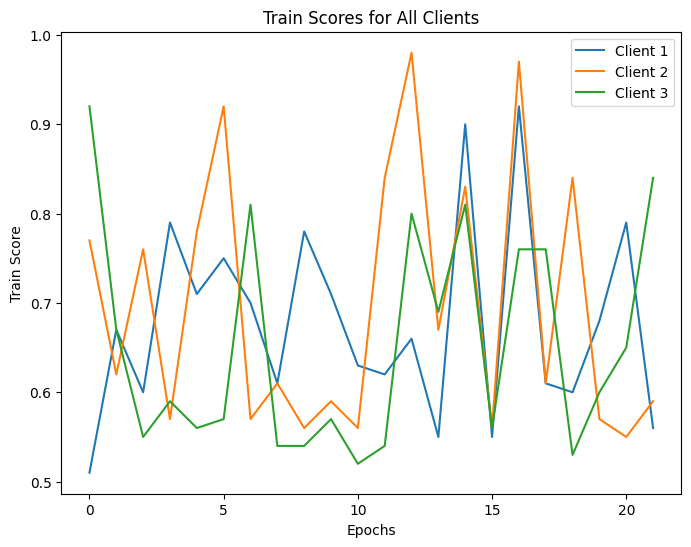

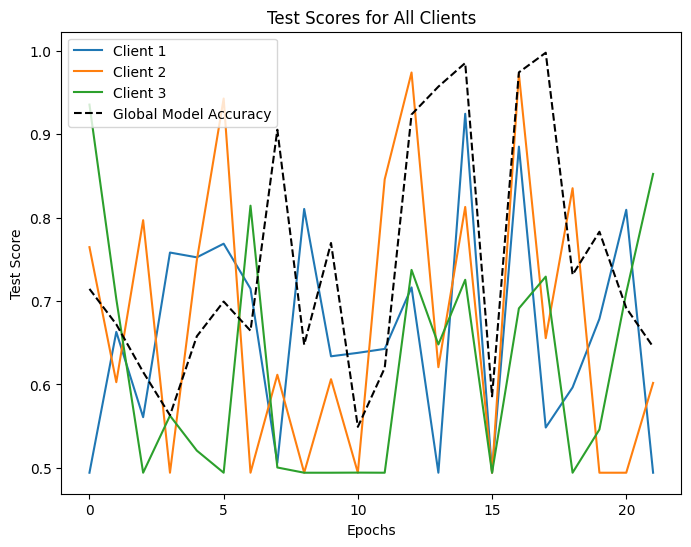

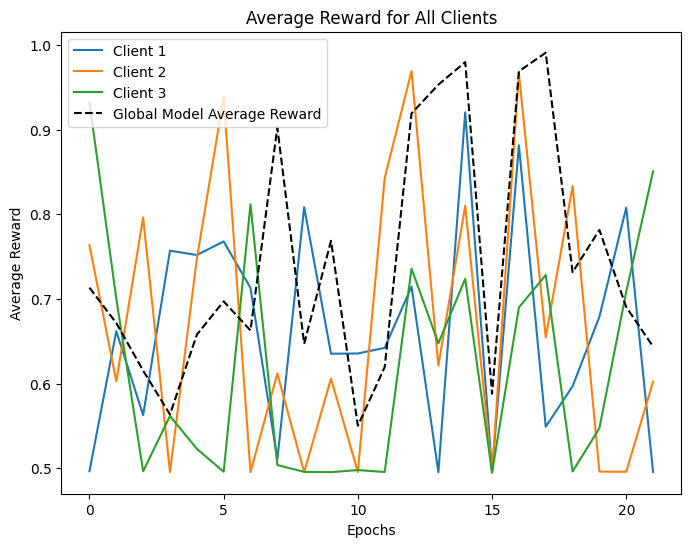

epoch: 22
Index: 0, Client: <__main__.Client object at 0x0000023426A059D0>
Train Sequences Shape: (100, 5)
Train Labels Shape: (100,)
Training Started
action: [0 0 0 0 0 1 1 1 0 0 1 1 1 0 1 0 1 0 1 1 1 1 1 0 1 0 0 1 0 1 0 0 1 1 0 1 0
 0 1 1 0 0 1 0 1 0 1 0 1 0 0 1 1 0 1 1 0 1 0 1 0 0 1 0 1 0 0 0 1 0 1 0 1 0
 0 1 1 0 0 1 0 1 0 0 0 1 0 1 1 0 1 0 0 1 1 0 1 1 1 0]
Loss_5: 35.79195468365867
sum_reward: 98.0
reward_avg: 0.98
Score: 0.9504666666666667
action: [0 0 0 0 0 1 1 1 0 0 1 1 1 0 1 0 1 0 1 1 1 1 1 0 1 0 0 1 0 1 0 0 1 1 0 1 0
 0 1 1 0 0 1 0 1 0 1 0 1 0 0 1 1 0 1 1 0 1 0 1 0 0 1 0 1 0 0 0 1 0 1 0 1 0
 0 1 1 0 0 1 0 1 0 0 0 1 0 1 1 0 1 0 0 1 1 0 1 1 1 0]
Loss_5: 43.2134022597204
sum_reward: 98.0
reward_avg: 0.98
Score: 0.9504666666666667
action: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Loss_5: 41.203293333444186
sum_reward: 49.

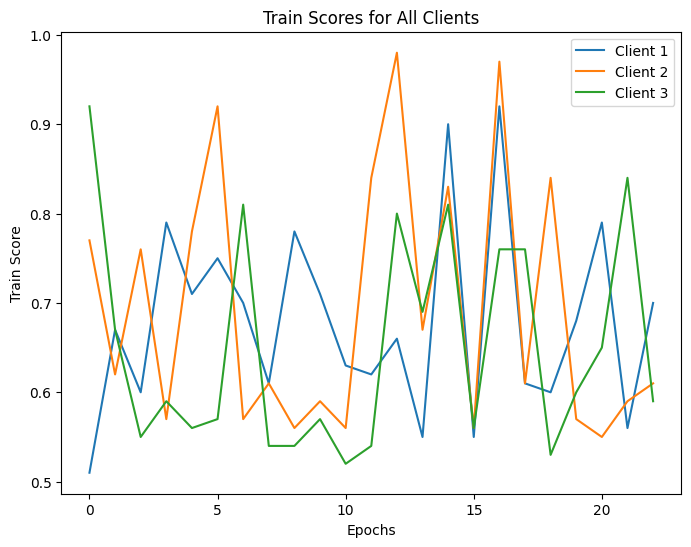

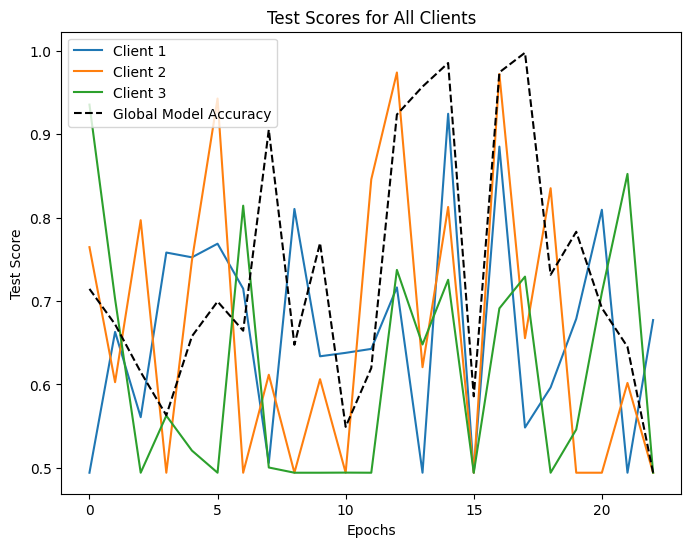

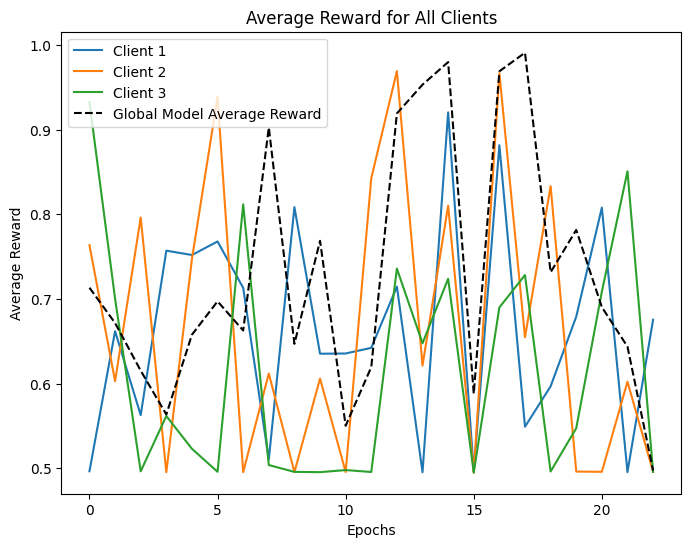

epoch: 23
Index: 0, Client: <__main__.Client object at 0x0000023426A059D0>
Train Sequences Shape: (100, 5)
Train Labels Shape: (100,)
Training Started
action: [1 0 0 1 1 1 0 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 1 1 0 1 0 0 1 1 1 1 0 0 1 0 1
 0 0 0 1 1 1 0 0 0 0 0 1 0 1 1 1 1 0 1 0 0 1 1 0 1 1 1 0 1 0 1 1 1 0 0 0 0
 1 0 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0 1 1 0 1 0 1 1 0 1]
Loss_5: 39.17726700078381
sum_reward: 98.0
reward_avg: 0.98
Score: 0.9826666666666667
action: [1 0 0 1 1 1 0 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 1 1 0 1 0 0 1 1 1 1 0 0 1 0 1
 0 0 0 1 1 1 0 0 0 0 0 1 0 1 1 1 1 0 1 0 0 1 1 0 1 1 1 0 1 0 1 1 1 0 0 0 0
 1 0 1 1 1 0 1 0 1 0 1 1 1 1 1 1 0 1 1 0 1 0 1 1 0 1]
Loss_5: 43.49748242336893
sum_reward: 97.0
reward_avg: 0.97
Score: 0.9826666666666667
action: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Loss_5: 44.22992364532214
sum_reward: 47.

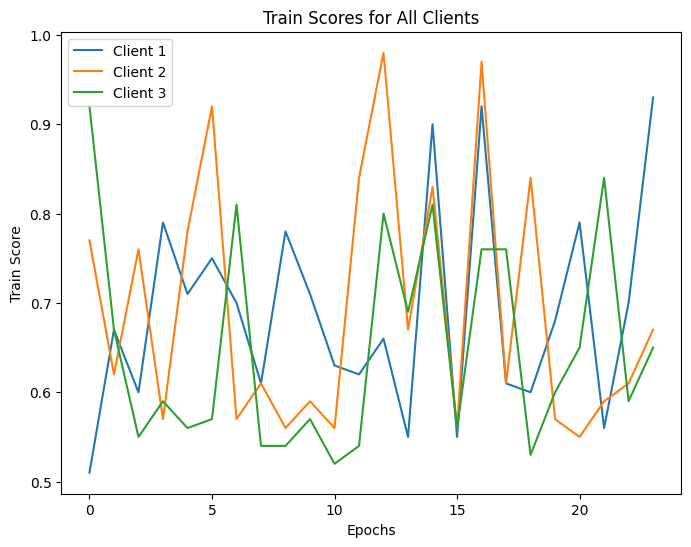

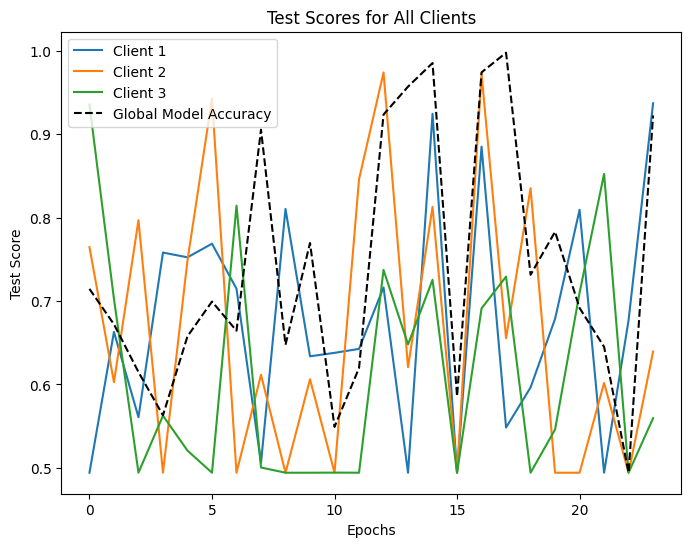

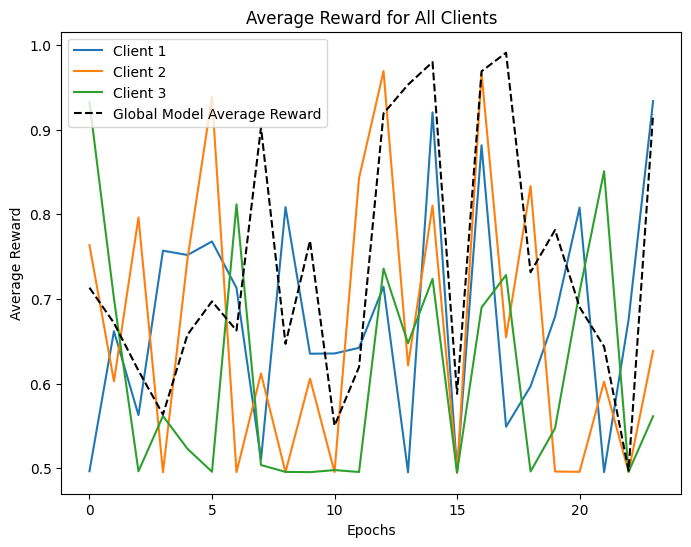

epoch: 24
Index: 0, Client: <__main__.Client object at 0x0000023426A059D0>
Train Sequences Shape: (100, 5)
Train Labels Shape: (100,)
Training Started
action: [1 1 0 0 0 1 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 1 0 0 1 0 1 0 0 1 1 0 1 1 0 1 1
 1 1 0 1 1 1 0 0 1 0 1 0 0 1 1 1 1 0 0 0 0 1 1 0 1 1 0 1 1 1 1 0 1 0 0 1 1
 1 0 0 1 1 0 0 1 1 0 1 0 1 1 1 1 1 0 0 1 1 0 0 0 0 1]
Loss_5: 36.47555987221414
sum_reward: 100.0
reward_avg: 1.0
Score: 0.9998
action: [1 1 0 0 0 1 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 1 0 0 1 0 1 0 0 1 1 0 1 1 0 1 1
 1 1 0 1 1 1 0 0 1 0 0 0 0 1 1 1 1 0 0 0 0 1 1 0 1 1 0 1 1 1 1 0 1 0 0 1 1
 1 0 0 1 1 0 0 1 1 0 1 0 1 1 1 1 1 0 0 1 1 0 0 0 0 1]
Loss_5: 43.411784415276045
sum_reward: 99.0
reward_avg: 0.99
Score: 0.9998
action: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Loss_5: 42.59390514157084
sum_reward: 48.0
reward_avg: 0.48
Scor

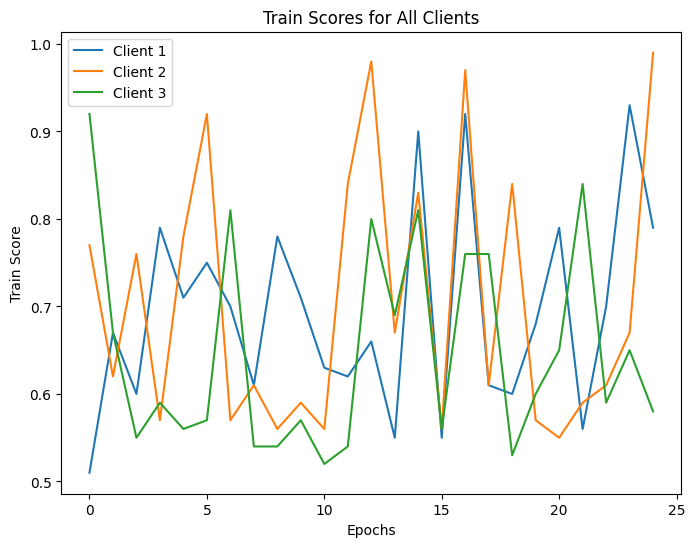

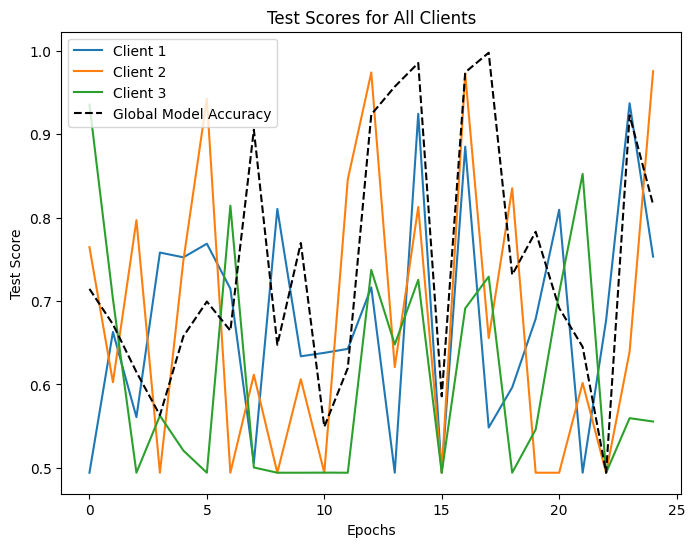

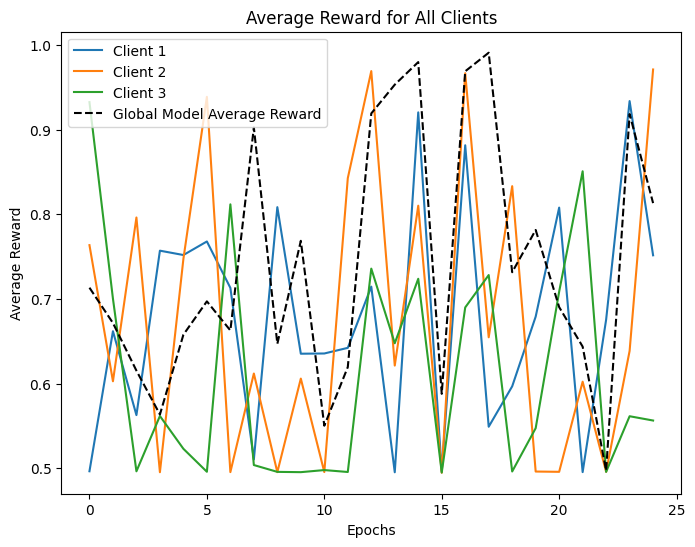

In [138]:
global_model_weights = {}
global_model_accuracy = []
global_model_avg_reward = []

for epoch in range(num_epochs):
  global_model_weights[epoch] = []
  epoch_weights = []
  print(f"epoch: {epoch}")

  for index, client in enumerate(clients):
    print(f"Index: {index}, Client: {client}")

    objective_func_vals = []
    
    if client.primary_model is None:
      train_score_q, test_score_q, model = train(data = client.data[epoch])
      avg_reward = getAvgReward(model.weights)
      client.models.append(model)
      client.test_scores.append(test_score_q)
      client.train_scores.append(train_score_q)
      client.avg_reward.append(avg_reward)
      
      # Print the values
      print("Train Score:", train_score_q)
      print("Test Score:", test_score_q)
      print("\n\n")
      epoch_weights.append(model.weights)

    else:
      train_score_q, test_score_q, model = train(data = client.data[epoch], model = client.primary_model)
      avg_reward = getAvgReward(model.weights)
      client.models.append(model)
      client.test_scores.append(test_score_q)
      client.train_scores.append(train_score_q)
      client.avg_reward.append(avg_reward)
      print("Train Score:", train_score_q)
      print("Test Score:", test_score_q)
      print("\n\n")
      epoch_weights.append(model.weights)

  if(epoch != 0):
    epoch_weights.append(global_model_weights[epoch-1])

  average_weights = sum(epoch_weights) / len(epoch_weights)

  global_model_weights[epoch] = average_weights
  new_model_with_global_weights = create_model_with_weights(global_model_weights[epoch])
  for index, client in enumerate(clients):
    client.primary_model = new_model_with_global_weights

  global_accuracy = getAccuracy(global_model_weights[epoch])
  global_avg_rewatd = getAvgReward(global_model_weights[epoch])
  print(f"Global Model Accuracy In Epoch {epoch}: {global_accuracy}")
  print(f"Global Model Avg Reward In Epoch {epoch}: {global_avg_rewatd}")
  print("----------------------------------------------------------")
  global_model_accuracy.append(global_accuracy)
  global_model_avg_reward.append(global_avg_rewatd)
  callback_results(clients,global_model_accuracy,global_model_avg_reward)
  